## Parsing VCF

In [1]:
# Parsing VCF
from pysam import VariantFile

# Data Analysis
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
from patsy import dmatrices

mpl.rcParams['figure.dpi'] = 300
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Important infos

- All the genotypes found in ancestor are the following:
  - <pre>(None), (0,0), (0,1), (1,1), (0,2), (1,2), (2,2), (2,3), (0,4), (0,3), (3,4), (3,3), (1,3), (2,4)</pre>
  
<pre>
  - (None): 2474024
  - <b>(0,0): 96520920</b> <-|
  - <b>(0,1): 1812246</b>  <-|-- Only useful genotypes : drop the others
  - <b>(1,1): 11861</b>    <-|
  - (0,2): 1901
  - (1,2): 3736
  - (2,2): 72
  - (2,3): 8
  - (0,4): 4
  - (0,3): 34
  - (3,4): 1
  - (3,3): 3
  - (1,3): 9
  - (2,4): 1
</pre>

If ancestor can be 0/0 0/1 or 1/1 now the possible changes (LOH) are:
- Anc 0/1 -> Offspring 1/1
- Anc 0/1 -> Offspring 0/0
- Anc 0/0 -> Offspring 0/1 (or 2 or 3, ...)
- Anc 1/1 -> Offspring 1/2 (or 3 or 4, ...)
- Anc 0/0 -> Offspring 1/1 (or 2/2, ...)

## 1. Get numbers of LOH

Genotype goes from heterozygous (e.g.: 0/1) to homozygous (e.g.: 0/0 or 1/1) 

## ME

### Run once

In [2]:
offsprings = {
    'D2A1':[0,0], # Number of ancestor heterozygous called in offspring, number of ancestor heterozygous lost in offspring
    'D2B3':[0,0],
    'D2C1':[0,0],
    'D2C3':[0,0],
    'D3A1':[0,0],
    'D3A3':[0,0],
    'D4A3':[0,0],
    'D4B4':[0,0],
    'D5B3':[0,0],
    'D5C1':[0,0],
    'D5C3':[0,0],
    'H2A3':[0,0],
    'H2B4':[0,0],
    'H2C3':[0,0],
    'H3A4':[0,0],
    'H3C4':[0,0],
    'H4A4':[0,0],
    'H4C2':[0,0],
    'H5A2':[0,0],
    'H5A3':[0,0],
    'H5A4':[0,0],
    'H5C2':[0,0],
}

In [3]:
in_vcf = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/endpoint/merged_allsites.vcf"

vcf_in = VariantFile(in_vcf)  # auto-detect input format
ancestor = "ancestor"

all_ancestor_alleles = {}

#print(rec.samples.keys())

# For record in sample
for n, rec in enumerate(vcf_in) :
    if n % 1000000 == 0 :
        print("Elapsed records: {}".format(n))
    
    ancestor_data = rec.samples[ancestor]
    ancestor_called = True if None not in ancestor_data["GT"] else False # store True if ancestor is called
    
    if ancestor_called :
        ancestor_alleles = set(sorted(ancestor_data["GT"]))
    else :
        continue
    
    if ancestor_alleles not in [{0},{0,1},{1,0},{1}] :
        continue
    
    # For sample in record
    for name, data in rec.samples.items() :

        # Skip ancestor
        if name == "ancestor" :
            continue
        
        offspring_called = True if None not in data["GT"] else False # store True if ancestor is called
        if not offspring_called :
            continue
        else :
            offspring_alleles = set(sorted(data["GT"]))
            
            if ancestor_alleles == {0,1} : # ancestor 0/0

                # possible offsprings: identical, heterozygous or homozygous and different
                if offspring_alleles == ancestor_alleles :
                    offsprings[name][0] += 1
                elif offspring_alleles != {None} and len(offspring_alleles) == 1 :
                    offsprings[name][0] += 1 # called
                    offsprings[name][1] += 1 # LOH

vcf_in.close()

Elapsed records: 0
Elapsed records: 1000000
Elapsed records: 2000000
Elapsed records: 3000000
Elapsed records: 4000000
Elapsed records: 5000000
Elapsed records: 6000000
Elapsed records: 7000000
Elapsed records: 8000000
Elapsed records: 9000000
Elapsed records: 10000000
Elapsed records: 11000000
Elapsed records: 12000000
Elapsed records: 13000000
Elapsed records: 14000000
Elapsed records: 15000000
Elapsed records: 16000000
Elapsed records: 17000000
Elapsed records: 18000000
Elapsed records: 19000000
Elapsed records: 20000000
Elapsed records: 21000000
Elapsed records: 22000000
Elapsed records: 23000000
Elapsed records: 24000000
Elapsed records: 25000000
Elapsed records: 26000000
Elapsed records: 27000000
Elapsed records: 28000000
Elapsed records: 29000000
Elapsed records: 30000000
Elapsed records: 31000000
Elapsed records: 32000000
Elapsed records: 33000000
Elapsed records: 34000000
Elapsed records: 35000000
Elapsed records: 36000000
Elapsed records: 37000000
Elapsed records: 38000000
El

#### Proportions of LOH

In [5]:
for o, d in offsprings.items() :
    print("{}: {:.4f}".format(o, d[1]/d[0]))

D2A1: 0.0301
D2B3: 0.0667
D2C1: 0.0268
D2C3: 0.0250
D3A1: 0.0288
D3A3: 0.0234
D4A3: 0.0279
D4B4: 0.0247
D5B3: 0.0374
D5C1: 0.0228
D5C3: 0.1296
H2A3: 0.0273
H2B4: 0.0448
H2C3: 0.0427
H3A4: 0.0315
H3C4: 0.0225
H4A4: 0.0398
H4C2: 0.0353
H5A2: 0.0407
H5A3: 0.0236
H5A4: 0.0335
H5C2: 0.0230


In [6]:
# Store in a new variable called offsprings_MA
offsprings_ME = {k:v for k, v in offsprings.items()}

In [4]:
print(offsprings_ME)

{'D2A1': [1841121, 55364], 'D2B3': [1848635, 123356], 'D2C1': [1844127, 49511], 'D2C3': [1843042, 46157], 'D3A1': [1841573, 53030], 'D3A3': [1845192, 43259], 'D4A3': [1842419, 51402], 'D4B4': [1844335, 45625], 'D5B3': [1841348, 68816], 'D5C1': [1844118, 41957], 'D5C3': [1842318, 238713], 'H2A3': [1849383, 50415], 'H2B4': [1843725, 82561], 'H2C3': [1842824, 78758], 'H3A4': [1842404, 58052], 'H3C4': [1843867, 41499], 'H4A4': [1845169, 73354], 'H4C2': [1842026, 65045], 'H5A2': [1842288, 75029], 'H5A3': [1843473, 43473], 'H5A4': [1842236, 61746], 'H5C2': [1844344, 42338]}


### Results (skip above)

In [2]:
offsprings_ME = {'D2A1': [1841121, 55364], 'D2B3': [1848635, 123356], 'D2C1': [1844127, 49511], 'D2C3': [1843042, 46157], 'D3A1': [1841573, 53030], 'D3A3': [1845192, 43259], 'D4A3': [1842419, 51402], 'D4B4': [1844335, 45625], 'D5B3': [1841348, 68816], 'D5C1': [1844118, 41957], 'D5C3': [1842318, 238713], 'H2A3': [1849383, 50415], 'H2B4': [1843725, 82561], 'H2C3': [1842824, 78758], 'H3A4': [1842404, 58052], 'H3C4': [1843867, 41499], 'H4A4': [1845169, 73354], 'H4C2': [1842026, 65045], 'H5A2': [1842288, 75029], 'H5A3': [1843473, 43473], 'H5A4': [1842236, 61746], 'H5C2': [1844344, 42338]}

## GR

### Run once

In [7]:
offsprings = {
    "30D_C13_E3":[0,0], # Number of ancestor heterozygous called in offspring, number of ancestor heterozygous lost in offspring
    "30D_C38_E4":[0,0],
    "30D_C38_E5":[0,0],
    "30D_C52_E5":[0,0],
    "30H_C36_E5":[0,0],
    "30H_C3_E4":[0,0],
    "30H_C3_E5":[0,0],
    "30H_C48_E5":[0,0],
    "P0_C27_E5":[0,0],
    "P0_C40_E5":[0,0],
    "P0_C9_E4":[0,0],
    "P0_C9_E5":[0,0],
    "P100_C30_E3":[0,0],
    "P100_C30_E4":[0,0],
    "P100_C8_E3":[0,0],
    "P100_C8_E4":[0,0],
    "P250_C17_E3":[0,0],
    "P250_C17_E4":[0,0],
    "P250_C8_E3":[0,0],
    "P250_C8_E4":[0,0],
    "P500_C16_E4":[0,0],
    "P500_C16_E5":[0,0],
    "P500_C18_E3":[0,0],
    "P500_C30_E3":[0,0],
}

In [8]:
in_vcf = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/jointgenotyping/merged_allsites.vcf"

vcf_in = VariantFile(in_vcf)  # auto-detect input format
ancestor = "ancestor"

all_ancestor_alleles = {}

# For record in sample
for n, rec in enumerate(vcf_in) :
    if n % 1000000 == 0 :
        print("Elapsed records: {}".format(n))
    
    ancestor_data = rec.samples[ancestor]
    ancestor_called = True if None not in ancestor_data["GT"] else False # store True if ancestor is called
    
    if ancestor_called :
        ancestor_alleles = set(sorted(ancestor_data["GT"]))
    else :
        continue
    
    if ancestor_alleles not in [{0},{0,1},{1,0},{1}] :
        continue
    
    # For sample in record
    for name, data in rec.samples.items() :

        # Skip ancestor
        if name == "ancestor" :
            continue
        
        offspring_called = True if None not in data["GT"] else False # store True if ancestor is called
        if not offspring_called :
            continue
        else :
            offspring_alleles = set(sorted(data["GT"]))
            
            if ancestor_alleles == {0,1} : # ancestor 0/0

                # possible offsprings: identical, heterozygous or homozygous and different
                if offspring_alleles == ancestor_alleles :
                    offsprings[name][0] += 1
                elif offspring_alleles != {None} and len(offspring_alleles) == 1 :
                    offsprings[name][0] += 1 # called
                    offsprings[name][1] += 1 # LOH

vcf_in.close()

Elapsed records: 0
Elapsed records: 1000000
Elapsed records: 2000000
Elapsed records: 3000000
Elapsed records: 4000000
Elapsed records: 5000000
Elapsed records: 6000000
Elapsed records: 7000000
Elapsed records: 8000000
Elapsed records: 9000000
Elapsed records: 10000000
Elapsed records: 11000000
Elapsed records: 12000000
Elapsed records: 13000000
Elapsed records: 14000000
Elapsed records: 15000000
Elapsed records: 16000000
Elapsed records: 17000000
Elapsed records: 18000000
Elapsed records: 19000000
Elapsed records: 20000000
Elapsed records: 21000000
Elapsed records: 22000000
Elapsed records: 23000000
Elapsed records: 24000000
Elapsed records: 25000000
Elapsed records: 26000000
Elapsed records: 27000000
Elapsed records: 28000000
Elapsed records: 29000000
Elapsed records: 30000000
Elapsed records: 31000000
Elapsed records: 32000000
Elapsed records: 33000000
Elapsed records: 34000000
Elapsed records: 35000000
Elapsed records: 36000000
Elapsed records: 37000000
Elapsed records: 38000000
El

In [9]:
print(offsprings)

{'30D_C13_E3': [1852488, 45127], '30D_C38_E4': [1842994, 42376], '30D_C38_E5': [1843211, 41067], '30D_C52_E5': [1842626, 42159], '30H_C36_E5': [1843835, 41208], '30H_C3_E4': [1843410, 42396], '30H_C3_E5': [1842681, 41924], '30H_C48_E5': [1844144, 40435], 'P0_C27_E5': [1842792, 41502], 'P0_C40_E5': [1844225, 41731], 'P0_C9_E4': [1843100, 42090], 'P0_C9_E5': [1843033, 42478], 'P100_C30_E3': [1851917, 46334], 'P100_C30_E4': [1852599, 47217], 'P100_C8_E3': [1852024, 44229], 'P100_C8_E4': [1851995, 46786], 'P250_C17_E3': [1851978, 43858], 'P250_C17_E4': [1851712, 45200], 'P250_C8_E3': [1851416, 42688], 'P250_C8_E4': [1851921, 46344], 'P500_C16_E4': [1843583, 43324], 'P500_C16_E5': [1842613, 44087], 'P500_C18_E3': [1852057, 76518], 'P500_C30_E3': [1844374, 60756]}


In [10]:
for o, d in offsprings.items() :
    print("{}: {:.4f}".format(o, d[1]/d[0]))

30D_C13_E3: 0.0244
30D_C38_E4: 0.0230
30D_C38_E5: 0.0223
30D_C52_E5: 0.0229
30H_C36_E5: 0.0223
30H_C3_E4: 0.0230
30H_C3_E5: 0.0228
30H_C48_E5: 0.0219
P0_C27_E5: 0.0225
P0_C40_E5: 0.0226
P0_C9_E4: 0.0228
P0_C9_E5: 0.0230
P100_C30_E3: 0.0250
P100_C30_E4: 0.0255
P100_C8_E3: 0.0239
P100_C8_E4: 0.0253
P250_C17_E3: 0.0237
P250_C17_E4: 0.0244
P250_C8_E3: 0.0231
P250_C8_E4: 0.0250
P500_C16_E4: 0.0235
P500_C16_E5: 0.0239
P500_C18_E3: 0.0413
P500_C30_E3: 0.0329


In [11]:
offsprings_GR = { k:v for k, v in offsprings.items() }

### Skip above

In [2]:
offsprings_GR = {'30D_C13_E3': [1852488, 45127], '30D_C38_E4': [1842994, 42376], '30D_C38_E5': [1843211, 41067], '30D_C52_E5': [1842626, 42159], '30H_C36_E5': [1843835, 41208], '30H_C3_E4': [1843410, 42396], '30H_C3_E5': [1842681, 41924], '30H_C48_E5': [1844144, 40435], 'P0_C27_E5': [1842792, 41502], 'P0_C40_E5': [1844225, 41731], 'P0_C9_E4': [1843100, 42090], 'P0_C9_E5': [1843033, 42478], 'P100_C30_E3': [1851917, 46334], 'P100_C30_E4': [1852599, 47217], 'P100_C8_E3': [1852024, 44229], 'P100_C8_E4': [1851995, 46786], 'P250_C17_E3': [1851978, 43858], 'P250_C17_E4': [1851712, 45200], 'P250_C8_E3': [1851416, 42688], 'P250_C8_E4': [1851921, 46344], 'P500_C16_E4': [1843583, 43324], 'P500_C16_E5': [1842613, 44087], 'P500_C18_E3': [1852057, 76518], 'P500_C30_E3': [1844374, 60756]}

### 2. Store other variables per sample

- Cov: average coverage of sample
- Treat: experimental conditions in MA: H & D, in GR: 30H, 30D, 0Gy, 100Gy, 250Gy, 500Gy
- Exp: Experiment MA or GR
- Seq: sequencing run
- Gen: number of generations between ancestor and offspring

In [3]:
sequencing_run = {
    "D2A1": "GC078",
    "D3A1": "GC078",
    "D4A3": "GC078",
    "D5B3": "GC078",
    "D2B3": "GC078+GC100", # has a 50G
    "D5C3": "GC114", # has a 50G
    "D2C1": "GC114", # has a 50G
    "D2C3": "GC114", # has a 50G
    "D3A3": "GC114",  # has a 50G
    "D4B4": "GC114", # has a 50G
    "D5C1": "GC114", # has a 50G
    "H2A3": "GC078+GC100",
    "H2C3": "GC087",
    "H4C2": "GC087",
    "H5A3": "GC087",
    "H4A4": "GC078+GC100", # has a 50G
    "H5A2": "GC114", # has a 50G
    "H2B4": "GC114", # has a 50G
    "H3A4": "GC114", # has a 50G
    "H3C4": "GC114", # has a 50G
    "H5A4": "GC114", # has a 50G
    "H5C2": "GC114", # has a 50G
    "30H_C36_E5": "GC078",
    "30H_C3_E5":  "GC087",
    "30H_C48_E5": "GC078",
    "30H_C3_E4":  "GC087",
    "30D_C52_E5": "GC087",
    "30D_C38_E4": "GC087",
    "30D_C13_E3": "GC047",
    "30D_C38_E5": "GC078",
    "P0_C27_E5":  "GC078",
    "P0_C9_E5":   "GC087",
    "P0_C9_E4":   "GC087",
    "P0_C40_E5":  "GC087",
    "P100_C8_E4": "GC100",
    "P100_C30_E4":"GC100",
    "P100_C8_E3": "GC100",
    "P100_C30_E3":"GC100",
    "P250_C8_E3": "GC100",
    "P250_C17_E4":"GC100",
    "P250_C8_E4": "GC100",
    "P250_C17_E3":"GC100",
    "P500_C16_E5":"GC087",
    "P500_C16_E4":"GC087",
    "P500_C30_E3":"GC078",
    "P500_C18_E3":"GC047",
}

experiment = {
    "D2A1": "ME",
    "D3A1": "ME",
    "D4A3": "ME",
    "D5B3": "ME",
    "D2B3": "ME", # has a 50G
    "D5C3": "ME", # has a 50G
    "D2C1": "ME", # has a 50G
    "D2C3": "ME", # has a 50G
    "D3A3": "ME",  # has a 50G
    "D4B4": "ME", # has a 50G
    "D5C1": "ME", # has a 50G
    "H2A3": "ME",
    "H2C3": "ME",
    "H4C2": "ME",
    "H5A3": "ME",
    "H4A4": "ME", # has a 50G
    "H5A2": "ME", # has a 50G
    "H2B4": "ME", # has a 50G
    "H3A4": "ME", # has a 50G
    "H3C4": "ME", # has a 50G
    "H5A4": "ME", # has a 50G
    "H5C2": "ME", # has a 50G
    "30H_C36_E5": "GR",
    "30H_C3_E5":  "GR",
    "30H_C48_E5": "GR",
    "30H_C3_E4":  "GR",
    "30D_C52_E5": "GR",
    "30D_C38_E4": "GR",
    "30D_C13_E3": "GR",
    "30D_C38_E5": "GR",
    "P0_C27_E5":  "GR",
    "P0_C9_E5":   "GR",
    "P0_C9_E4":   "GR",
    "P0_C40_E5":  "GR",
    "P100_C8_E4": "GR",
    "P100_C30_E4":"GR",
    "P100_C8_E3": "GR",
    "P100_C30_E3":"GR",
    "P250_C8_E3": "GR",
    "P250_C17_E4":"GR",
    "P250_C8_E4": "GR",
    "P250_C17_E3":"GR",
    "P500_C16_E5":"GR",
    "P500_C16_E4":"GR",
    "P500_C30_E3":"GR",
    "P500_C18_E3":"GR",
}

generations = {
    "D2A1": 86,
    "D3A1": 87,
    "D4A3": 82,
    "D5B3": 83,
    "D2B3": 84, # has a 50G
    "D5C3": 81, # has a 50G
    "D2C1": 79, # has a 50G
    "D2C3": 75, # has a 50G
    "D3A3": 84,  # has a 50G
    "D4B4": 87, # has a 50G
    "D5C1": 79, # has a 50G
    "H2A3": 117,
    "H2C3": 122,
    "H4C2": 128,
    "H5A3": 128,
    "H4A4": 118, # has a 50G
    "H5A2": 132, # has a 50G
    "H2B4": 119, # has a 50G
    "H3A4": 129, # has a 50G
    "H3C4": 133, # has a 50G
    "H5A4": 131, # has a 50G
    "H5C2": 125, # has a 50G
    "30H_C36_E5": 1,
    "30H_C3_E5":  1,
    "30H_C48_E5": 1,
    "30H_C3_E4":  1,
    "30D_C52_E5": 1,
    "30D_C38_E4": 1,
    "30D_C13_E3": 1,
    "30D_C38_E5": 1,
    "P0_C27_E5":  1,
    "P0_C9_E5":   1,
    "P0_C9_E4":   1,
    "P0_C40_E5":  1,
    "P100_C8_E4": 1,
    "P100_C30_E4":1,
    "P100_C8_E3": 1,
    "P100_C30_E3":1,
    "P250_C8_E3": 1,
    "P250_C17_E4":1,
    "P250_C8_E4": 1,
    "P250_C17_E3":1,
    "P500_C16_E5":1,
    "P500_C16_E4":1,
    "P500_C30_E3":1,
    "P500_C18_E3":1,
}

clone = {
    "D2A1": "A",
    "D3A1": "B",
    "D4A3": "C",
    "D5B3": "D",
    "D2B3": "E", # has a 50G
    "D5C3": "F", # has a 50G
    "D2C1": "G", # has a 50G
    "D2C3": "H", # has a 50G
    "D3A3": "I",  # has a 50G
    "D4B4": "J", # has a 50G
    "D5C1": "K", # has a 50G
    "H2A3": "L",
    "H2C3": "M",
    "H4C2": "N",
    "H5A3": "O",
    "H4A4": "P", # has a 50G
    "H5A2": "Q", # has a 50G
    "H2B4": "R", # has a 50G
    "H3A4": "S", # has a 50G
    "H3C4": "T", # has a 50G
    "H5A4": "U", # has a 50G
    "H5C2": "V", # has a 50G
    "30H_C36_E5": "H_36", # GR
    "30H_C3_E5":  "H_03",
    "30H_C48_E5": "H_48",
    "30H_C3_E4":  "H_03",
    "30D_C52_E5": "D_52",
    "30D_C38_E4": "D_38",
    "30D_C13_E3": "D_13",
    "30D_C38_E5": "D_38",
    "P0_C27_E5":  "P0_27",
    "P0_C9_E5":   "P0_09",
    "P0_C9_E4":   "P0_09",
    "P0_C40_E5":  "P0_40",
    "P100_C8_E4": "P100_08",
    "P100_C30_E4":"P100_30",
    "P100_C8_E3": "P100_08",
    "P100_C30_E3":"P100_30",
    "P250_C8_E3": "P250_08",
    "P250_C17_E4":"P250_17",
    "P250_C8_E4": "P250_08",
    "P250_C17_E3":"P250_17",
    "P500_C16_E5":"P500_16",
    "P500_C16_E4":"P500_16",
    "P500_C30_E3":"P500_30",
    "P500_C18_E3":"P500_18",
}

egg = {
    "D2A1": "A",
    "D3A1": "B",
    "D4A3": "C",
    "D5B3": "D",
    "D2B3": "E", # has a 50G
    "D5C3": "F", # has a 50G
    "D2C1": "G", # has a 50G
    "D2C3": "H", # has a 50G
    "D3A3": "I",  # has a 50G
    "D4B4": "J", # has a 50G
    "D5C1": "K", # has a 50G
    "H2A3": "L",
    "H2C3": "M",
    "H4C2": "N",
    "H5A3": "O",
    "H4A4": "P", # has a 50G
    "H5A2": "Q", # has a 50G
    "H2B4": "R", # has a 50G
    "H3A4": "S", # has a 50G
    "H3C4": "T", # has a 50G
    "H5A4": "U", # has a 50G
    "H5C2": "V", # has a 50G
    "30H_C36_E5": "5", # GR
    "30H_C3_E5":  "5",
    "30H_C48_E5": "5",
    "30H_C3_E4":  "4",
    "30D_C52_E5": "5",
    "30D_C38_E4": "4",
    "30D_C13_E3": "3",
    "30D_C38_E5": "5",
    "P0_C27_E5":  "5",
    "P0_C9_E5":   "5",
    "P0_C9_E4":   "4",
    "P0_C40_E5":  "5",
    "P100_C8_E4": "4",
    "P100_C30_E4":"4",
    "P100_C8_E3": "3",
    "P100_C30_E3":"3",
    "P250_C8_E3": "3",
    "P250_C17_E4":"4",
    "P250_C8_E4": "4",
    "P250_C17_E3":"3",
    "P500_C16_E5":"5",
    "P500_C16_E4":"4",
    "P500_C30_E3":"3",
    "P500_C18_E3":"3",
}

condition = {
    "30H_C36_E5": "30H", # GR
    "30H_C3_E5":  "30H",
    "30H_C48_E5": "30H",
    "30H_C3_E4":  "30H",
    "30D_C52_E5": "30D",
    "30D_C38_E4": "30D",
    "30D_C13_E3": "30D",
    "30D_C38_E5": "30D",
    "P0_C27_E5":  "0Gy",
    "P0_C9_E5":   "0Gy",
    "P0_C9_E4":   "0Gy",
    "P0_C40_E5":  "0Gy",
    "P100_C8_E4": "100Gy",
    "P100_C30_E4":"100Gy",
    "P100_C8_E3": "100Gy",
    "P100_C30_E3":"100Gy",
    "P250_C8_E3": "250Gy",
    "P250_C17_E4":"250Gy",
    "P250_C8_E4": "250Gy",
    "P250_C17_E3":"250Gy",
    "P500_C16_E5":"500Gy",
    "P500_C16_E4":"500Gy",
    "P500_C30_E3":"500Gy",
    "P500_C18_E3":"500Gy",
    "D4A3": "D", # ME
    "D2B3": "D",
    "D5B3": "D",
    "D3A1": "D",
    "D2A1": "D",
    "D5C3": "D",
    "D2C1": "D",
    "D2C3": "D",
    "D3A3": "D",
    "D4B4": "D",
    "D5C1": "D",
    "H2A3": "H",
    "H4A4": "H",
    "H2C3": "H",
    "H5A3": "H",
    "H4C2": "H",
    "H5A2": "H",
    "H2B4": "H",
    "H3A4": "H",
    "H3C4": "H",
    "H5A4": "H",
    "H5C2": "H",
}

average_coverage = {
    "ancestor":   317.243345,
    "30H_C36_E5": 229.083585,
    "30H_C3_E5":  197.320137,
    "30H_C48_E5": 257.554100,
    "30H_C3_E4":  187.501969,
    "30D_C52_E5": 195.700611,
    "30D_C38_E4": 181.582242,
    "30D_C13_E3": 240.965491,
    "30D_C38_E5": 221.777690,
    "P0_C27_E5":  227.671318,
    "P0_C9_E5":   164.935194,
    "P0_C9_E4":   175.894534,
    "P0_C40_E5":  181.310899,
    "P100_C8_E4": 400.742327,
    "P100_C30_E4":454.110001,
    "P100_C8_E3": 384.147378,
    "P100_C30_E3":394.245924,
    "P250_C8_E3": 363.454235,
    "P250_C17_E4":404.220995,
    "P250_C8_E4": 310.580450,
    "P250_C17_E3":329.395252,
    "P500_C16_E5":177.171750,
    "P500_C16_E4":174.270106,
    "P500_C30_E3":261.256750,
    "P500_C18_E3":269.026861,
    "D4A3": 52.223664,
    "D2B3": 249.716188,
    "D5B3": 68.881659,
    "D3A1": 47.629285,
    "D2A1": 45.860435,
    "D5C3": 148.061010,
    "D2C1": 106.932090,
    "D2C3": 100.898788,
    "D3A3": 99.090162,
    "D4B4": 135.542376,
    "D5C1": 113.422220,
    "H2A3": 414.665703,
    "H4A4": 393.569612,
    "H2C3": 138.926260,
    "H5A3": 190.553356,
    "H4C2": 191.925505,
    "H5A2": 52.253995,
    "H2B4": 117.821225,
    "H3A4": 85.142573,
    "H3C4": 120.135379,
    "H5A4": 118.495047,
    "H5C2": 139.135646,
}

### Aesthetics & labels

In [4]:
conditions_colors = {
    "30H": (0.0,0.0,1.0,0.8), # blue
    "30H_del": (0.0,0.7,1.0,0.25), # turquoise
    "30D": (1.0,0.5,0.0,0.8), # orangered
    "30D_del": (1.0,0.75,0.0,0.25), # orange
    "0Gy": (0.5,0.5,0.5,0.8), # dark grey
    "0Gy_del": (0.7,0.7,0.7,0.25), # lighter grey
    "100Gy": (0.7,0.0,0.6,0.8), # purple
    "100Gy_del": (1.0,0.0,0.8,0.25), # pinkish
    "250Gy": (0.0,0.75,0.0,0.8), # darkgreen
    "250Gy_del": (0.0,1.0,0.0,0.25), # limegreen
    "500Gy": (1.0,0.0,0.0,0.8), # red
    "500Gy_del": (1.0,0.5,0.5,0.25), # pink
    "H": (0.0,0.0,1.0,0.8),
    "H_del": (0.0,0.7,1.0,0.25),
    "D": (1.0,0.25,0.0,0.8),
    "D_del": (1.0,0.75,0.0,0.25),
}

conditions_names = {
    "30H": "GR Hydrated",
    "30D": "GR Desiccated",
    "0Gy": "GR 0Gy IR",
    "100Gy": "GR 100Gy IR",
    "250Gy": "GR 250Gy IR",
    "500Gy": "GR 500Gy IR",
    "H": "ME Hydrated",
    "D": "ME Desiccated"
}

conditions_shape = {
    "30H": "o",
    "30D": "o",
    "0Gy": "o",
    "100Gy": "o",
    "250Gy": "o",
    "500Gy": "o",
    "H": "d",
    "D": "d"
}

In [6]:
print(offsprings_GR)

{'30D_C13_E3': [1852488, 45127], '30D_C38_E4': [1842994, 42376], '30D_C38_E5': [1843211, 41067], '30D_C52_E5': [1842626, 42159], '30H_C36_E5': [1843835, 41208], '30H_C3_E4': [1843410, 42396], '30H_C3_E5': [1842681, 41924], '30H_C48_E5': [1844144, 40435], 'P0_C27_E5': [1842792, 41502], 'P0_C40_E5': [1844225, 41731], 'P0_C9_E4': [1843100, 42090], 'P0_C9_E5': [1843033, 42478], 'P100_C30_E3': [1851917, 46334], 'P100_C30_E4': [1852599, 47217], 'P100_C8_E3': [1852024, 44229], 'P100_C8_E4': [1851995, 46786], 'P250_C17_E3': [1851978, 43858], 'P250_C17_E4': [1851712, 45200], 'P250_C8_E3': [1851416, 42688], 'P250_C8_E4': [1851921, 46344], 'P500_C16_E4': [1843583, 43324], 'P500_C16_E5': [1842613, 44087], 'P500_C18_E3': [1852057, 76518], 'P500_C30_E3': [1844374, 60756]}


In [7]:
data = {
    "id":[],
    "trials":[],
    "successes":[],
    "coverage":[],
    "treatment":[],
    "generations":[],
    "experiment":[],
    "sequencing_run":[],
    "egg":[],
    "clone":[],
}

for sample in offsprings_GR.keys() :
    data["id"].append(sample)
    data["trials"].append(offsprings_GR[sample][0])
    data["successes"].append(offsprings_GR[sample][1])
    data["coverage"].append(average_coverage[sample])
    data["treatment"].append(condition[sample])
    data["generations"].append(generations[sample])
    data["experiment"].append(experiment[sample])
    data["sequencing_run"].append(sequencing_run[sample])
    data["clone"].append(clone[sample])
    data["egg"].append(egg[sample])

df = pd.DataFrame().from_dict(data)
df = df.assign(Y=df.apply(lambda x: x["successes"]/x["trials"], axis="columns"))
df = df.assign(failures=df.apply(lambda x: x["trials"]-x["successes"], axis="columns"))
df = df.assign(logit_success=np.log(df['Y'] / (1 - df['Y'])))
df

,id,trials,successes,coverage,treatment,generations,experiment,sequencing_run,egg,clone,Y,failures,logit_success
0,30D_C13_E3,1852488,45127,240.965491,30D,1,GR,GC047,3,D_13,0.024360,1807361,-3.690142
1,30D_C38_E4,1842994,42376,181.582242,30D,1,GR,GC087,4,D_38,0.022993,1800618,-3.749303
2,30D_C38_E5,1843211,41067,221.777690,30D,1,GR,GC078,5,D_38,0.022280,1802144,-3.781527
3,30D_C52_E5,1842626,42159,195.700611,30D,1,GR,GC087,5,D_52,0.022880,1800467,-3.754353
4,30H_C36_E5,1843835,41208,229.083585,30H,1,GR,GC078,5,H_36,0.022349,1802627,-3.778368
5,30H_C3_E4,1843410,42396,187.501969,30H,1,GR,GC087,4,H_03,0.022999,1801014,-3.749051
6,30H_C3_E5,1842681,41924,197.320137,30H,1,GR,GC087,5,H_03,0.022752,1800757,-3.760104
7,30H_C48_E5,1844144,40435,257.554100,30H,1,GR,GC078,5,H_48,0.021926,1803709,-3.797905
8,P0_C27_E5,1842792,41502,227.671318,0Gy,1,GR,GC078,5,P0_27,0.022521,1801290,-3.770517
9,P0_C40_E5,1844225,41731,181.310899,0Gy,1,GR,GC087,5,P0_40,0.022628,1802494,-3.765682


# Only GR experiment

### Controling for random effects such as which clone and which egg

### Using linear mixed models (LMM)
- Model *treatment* as a fixed effect (expected biological driver)
- Model *clone* as a fixed effect
- Model *coverage* as a random effect

In [28]:
def get_dose(t):
    if "Gy" in t:
        return int(t[:-2])
    else:
        return np.nan

### Prepare dataset
data_lmm = df.query('experiment == "GR"')[['id', 'trials', 'successes', 'coverage', 'treatment', 'clone']]
data_lmm = data_lmm.rename(columns={'trials':'sites', 'successes':'LOH'})
data_lmm = data_lmm.copy()
data_lmm = data_lmm.apply(lambda col: col.cat.remove_unused_categories() if col.dtype.name == 'category' else col)
##### Transform LOH in log because long-tailed
data_lmm["log_LOH"] = np.log1p(data_lmm["LOH"])
##### Add dose
data_lmm = data_lmm.assign(
    **{'dose': data_lmm['treatment'].apply(get_dose)}
)
data_lmm_IR = data_lmm.loc[~data_lmm['id'].apply(lambda sample_name: sample_name.startswith('30'))]

In [29]:
print(data_lmm.to_csv(index=False))

id,sites,LOH,coverage,treatment,clone,log_LOH,dose
30D_C13_E3,1852488,45127,240.965491,30D,D_13,10.717258175419811,
30D_C38_E4,1842994,42376,181.582242,30D,D_38,10.654361041209096,
30D_C38_E5,1843211,41067,221.77769,30D,D_38,10.622984508418856,
30D_C52_E5,1842626,42159,195.700611,30D,D_52,10.649227183215244,
30H_C36_E5,1843835,41208,229.083585,30H,H_36,10.626411958083574,
30H_C3_E4,1843410,42396,187.501969,30H,H_03,10.654832883999834,
30H_C3_E5,1842681,41924,197.320137,30H,H_03,10.64363758669141,
30H_C48_E5,1844144,40435,257.5541,30H,H_48,10.607475756273947,
P0_C27_E5,1842792,41502,227.671318,0Gy,P0_27,10.633520992762682,0.0
P0_C40_E5,1844225,41731,181.310899,0Gy,P0_40,10.63902349958786,0.0
P0_C9_E4,1843100,42090,175.894534,0Gy,P0_09,10.647589220094883,0.0
P0_C9_E5,1843033,42478,164.935194,0Gy,P0_09,10.656765115149097,0.0
P100_C30_E3,1851917,46334,394.245924,100Gy,P100_30,10.743652894020792,100.0
P100_C30_E4,1852599,47217,454.110001,100Gy,P100_30,10.762530454808159,100.0
P100_C8_E3,185

In [30]:
##### Model 1
model_1 = smf.mixedlm("log_LOH ~ treatment + coverage", 
                    data=data_lmm, 
                    groups=data_lmm["clone"])
result_1 = model_1.fit()
print(result_1.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    log_LOH
No. Observations:    24         Method:                REML   
No. Groups:          16         Scale:                 0.0009 
Min. group size:     1          Log-Likelihood:        10.8743
Max. group size:     2          Converged:             Yes    
Mean group size:     1.5                                      
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          10.619    0.103 102.818 0.000 10.416 10.821
treatment[T.100Gy]  0.072    0.141   0.510 0.610 -0.204  0.348
treatment[T.250Gy]  0.043    0.130   0.329 0.742 -0.211  0.297
treatment[T.30D]    0.024    0.103   0.232 0.816 -0.179  0.227
treatment[T.30H]   -0.018    0.104  -0.170 0.865 -0.221  0.186
treatment[T.500Gy]  0.332    0.105   3.176 0.001  0.127  0.537
cover

In [31]:
#### Model 2: no treatment
model_2 = smf.mixedlm("log_LOH ~ coverage", 
                    data=data_lmm, 
                    groups=data_lmm["clone"])
result_2 = model_2.fit()
print(result_2.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_LOH
No. Observations: 24      Method:             REML   
No. Groups:       16      Scale:              0.0009 
Min. group size:  1       Log-Likelihood:     11.4056
Max. group size:  2       Converged:          Yes    
Mean group size:  1.5                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept 10.710    0.089 119.725 0.000 10.535 10.885
coverage   0.000    0.000   0.220 0.826 -0.001  0.001
Group Var  0.027    0.616                            



In [32]:
#### Model 3: no random effect
model_3 = smf.ols("log_LOH ~ treatment + coverage", data=data_lmm)
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:                log_LOH   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     4.738
Date:                Thu, 11 Sep 2025   Prob (F-statistic):            0.00521
Time:                        18:13:46   Log-Likelihood:                 25.536
No. Observations:                  24   AIC:                            -37.07
Df Residuals:                      17   BIC:                            -28.82
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.3208      0

In [34]:
#### Model 4: IR only no treatment
model_4 = smf.mixedlm("log_LOH ~ dose + coverage", 
                    data=data_lmm_IR, 
                    groups=data_lmm_IR["clone"])
result_4 = model_4.fit()
print(result_4.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_LOH
No. Observations: 16      Method:             REML   
No. Groups:       10      Scale:              0.0011 
Min. group size:  1       Log-Likelihood:     -0.6505
Max. group size:  2       Converged:          Yes    
Mean group size:  1.6                                
-----------------------------------------------------
           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  10.608    0.119 89.193 0.000 10.375 10.842
dose        0.001    0.000  2.693 0.007  0.000  0.001
coverage    0.000    0.000  0.263 0.793 -0.001  0.001
Group Var   0.023    0.551                           



In [ ]:
def do_model(model_string) :
    # Model
    # ex model_string: 'successes+failures ~ coverage + C(treatment) + generations + C(experiment) + C(sequencing_run)'
    y, X = dmatrices(model_string, data=df, return_type='dataframe')
    glm_binom = sm.GLM(y, X, family=sm.families.Binomial())
    res = glm_binom.fit()
    
    nobs = res.nobs
    xx = y.iloc[:,0]/y.sum(1)
    yhat = res.mu

    print("AIC: ", res.aic)
    #print("BIC: ", res.bic)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ax[0].scatter(yhat, xx, zorder=10, facecolor=cycle[0]+"80", ec="k", lw=0.5)
    line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
    abline_plot(model_results=line_fit, ax=ax[0], zorder=10, color="k", lw=1.5, label="fit")
    
    ax[0].grid(zorder=1)
    ax[0].set_title('Model Fit Plot')
    ax[0].set_ylabel('Observed values')
    ax[0].set_xlabel('Fitted values')
    ax[0].legend()

    ax[1].scatter(yhat, res.resid_pearson, zorder=10, facecolor=cycle[0]+"80", ec="k", lw=0.5)
    ax[1].plot([0.01,0.06],[0,0], lw=0.5, color="k", zorder=2)
    for x, y in zip(yhat, res.resid_pearson) :
        ax[1].plot([x,x], [0,y], color="k", lw=0.3, zorder=5)

    ax[1].grid(zorder=1)
    ax[1].set_xlim(0.01, 0.06)
    ax[1].set_title('Residual Dependence Plot')
    ax[1].set_ylabel('Pearson Residuals')
    ax[1].set_xlabel('Fitted values')

    plt.subplots_adjust(wspace=0.3)
    
    plt.show()
    
    return res

<a id="glm1"></a>
### GLM 1 All variables no interactions

In [ ]:
glm, mix_lm = get_models(df, groupvar='clone',
    model_string_glm = 'successes+failures ~ coverage + C(treatment) + generations + C(experiment) + C(sequencing_run)',
    model_string_mixedlm = 'logit_success ~ C(treatment)',
    )
glm.summary()

<a id="glm2"></a>
### GLM 2 All variables + interactions cov:treat & exp:gen

In [19]:
res = do_model('successes+failures ~ coverage + C(treatment) + generations + C(experiment) + C(sequencing_run) + C(experiment):generations + C(treatment):coverage')
res.summary()

AIC:  226746.1602602947


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       25
Model Family:                       Binomial   Df Model:                           20
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -1.1335e+05
Date:                       Wed, 30 Apr 2025   Deviance:                   2.2612e+05
Time:                               20:22:30   Pearson chi2:                 2.42e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.8868      0.018     48.201      0.000       0.851       0.923
C(treatment)[T.100Gy]               -1.9051      0.027    -70.879      0.000      -1.958      -1.852
C(treatment)[T.250Gy]               -1.6014      0.022    -71.989      0.000      -1.645      -1.558
C(treatment)[T.30D]                  1.7771      0.033     54.159      0.000       1.713       1.841
C(treatment)[T.30H]                  0.3306      0.028     11.675      0.000       0.275       0.386
C(treatment)[T.500Gy]               -1.7248      0.023    -73.936      0.000      -1.771      -1.679
C(treatment)[T.D]                   -1.7615      0.007   -249.909      0.000      -1.775      -1.748
C(treatment)[T.H]                    1.4331      0.013    106.841      0.000       1.407       1.459
C(experiment)[T.ME]                 -0.3284      0.016    -20.150      0.000      -0.360      -0.296
C(sequencing_run)[T.GC078]          -0.4076      0.005    -81.674      0.000      -0.417      -0.398
C(sequencing_run)[T.GC078+GC100]    -3.0801      0.013   -244.566      0.000      -3.105      -3.055
C(sequencing_run)[T.GC087]          -1.6000      0.008   -191.674      0.000      -1.616      -1.584
C(sequencing_run)[T.GC100]          -3.5065      0.025   -141.037      0.000      -3.555      -3.458
C(sequencing_run)[T.GC114]          -1.3802      0.007   -189.800      0.000      -1.394      -1.366
coverage                            -0.0210      0.000   -150.555      0.000      -0.021      -0.021
C(treatment)[T.100Gy]:coverage       0.0217      0.000    132.078      0.000       0.021       0.022
C(treatment)[T.250Gy]:coverage       0.0208      0.000    134.281      0.000       0.021       0.021
C(treatment)[T.30D]:coverage        -0.0081      0.000    -49.271      0.000      -0.008      -0.008
C(treatment)[T.30H]:coverage     -8.918e-05      0.000     -0.643      0.520      -0.000       0.000
C(treatment)[T.500Gy]:coverage       0.0104      0.000     87.113      0.000       0.010       0.011
C(treatment)[T.D]:coverage           0.0399      0.000    226.603      0.000       0.040       0.040
C(treatment)[T.H]:coverage           0.0251      0.000    164.945      0.000       0.025       0.025
generations                          0.5902      0.014     43.017      0.000       0.563       0.617
C(experiment)[T.ME]:generations     -0.6249      0.014    -45.693      0.000      -0.652      -0.598
====================================================================================================
"""

<a id="glm3"></a>
### GLM 3 coverage + treatment

AIC:  392073.61945370614


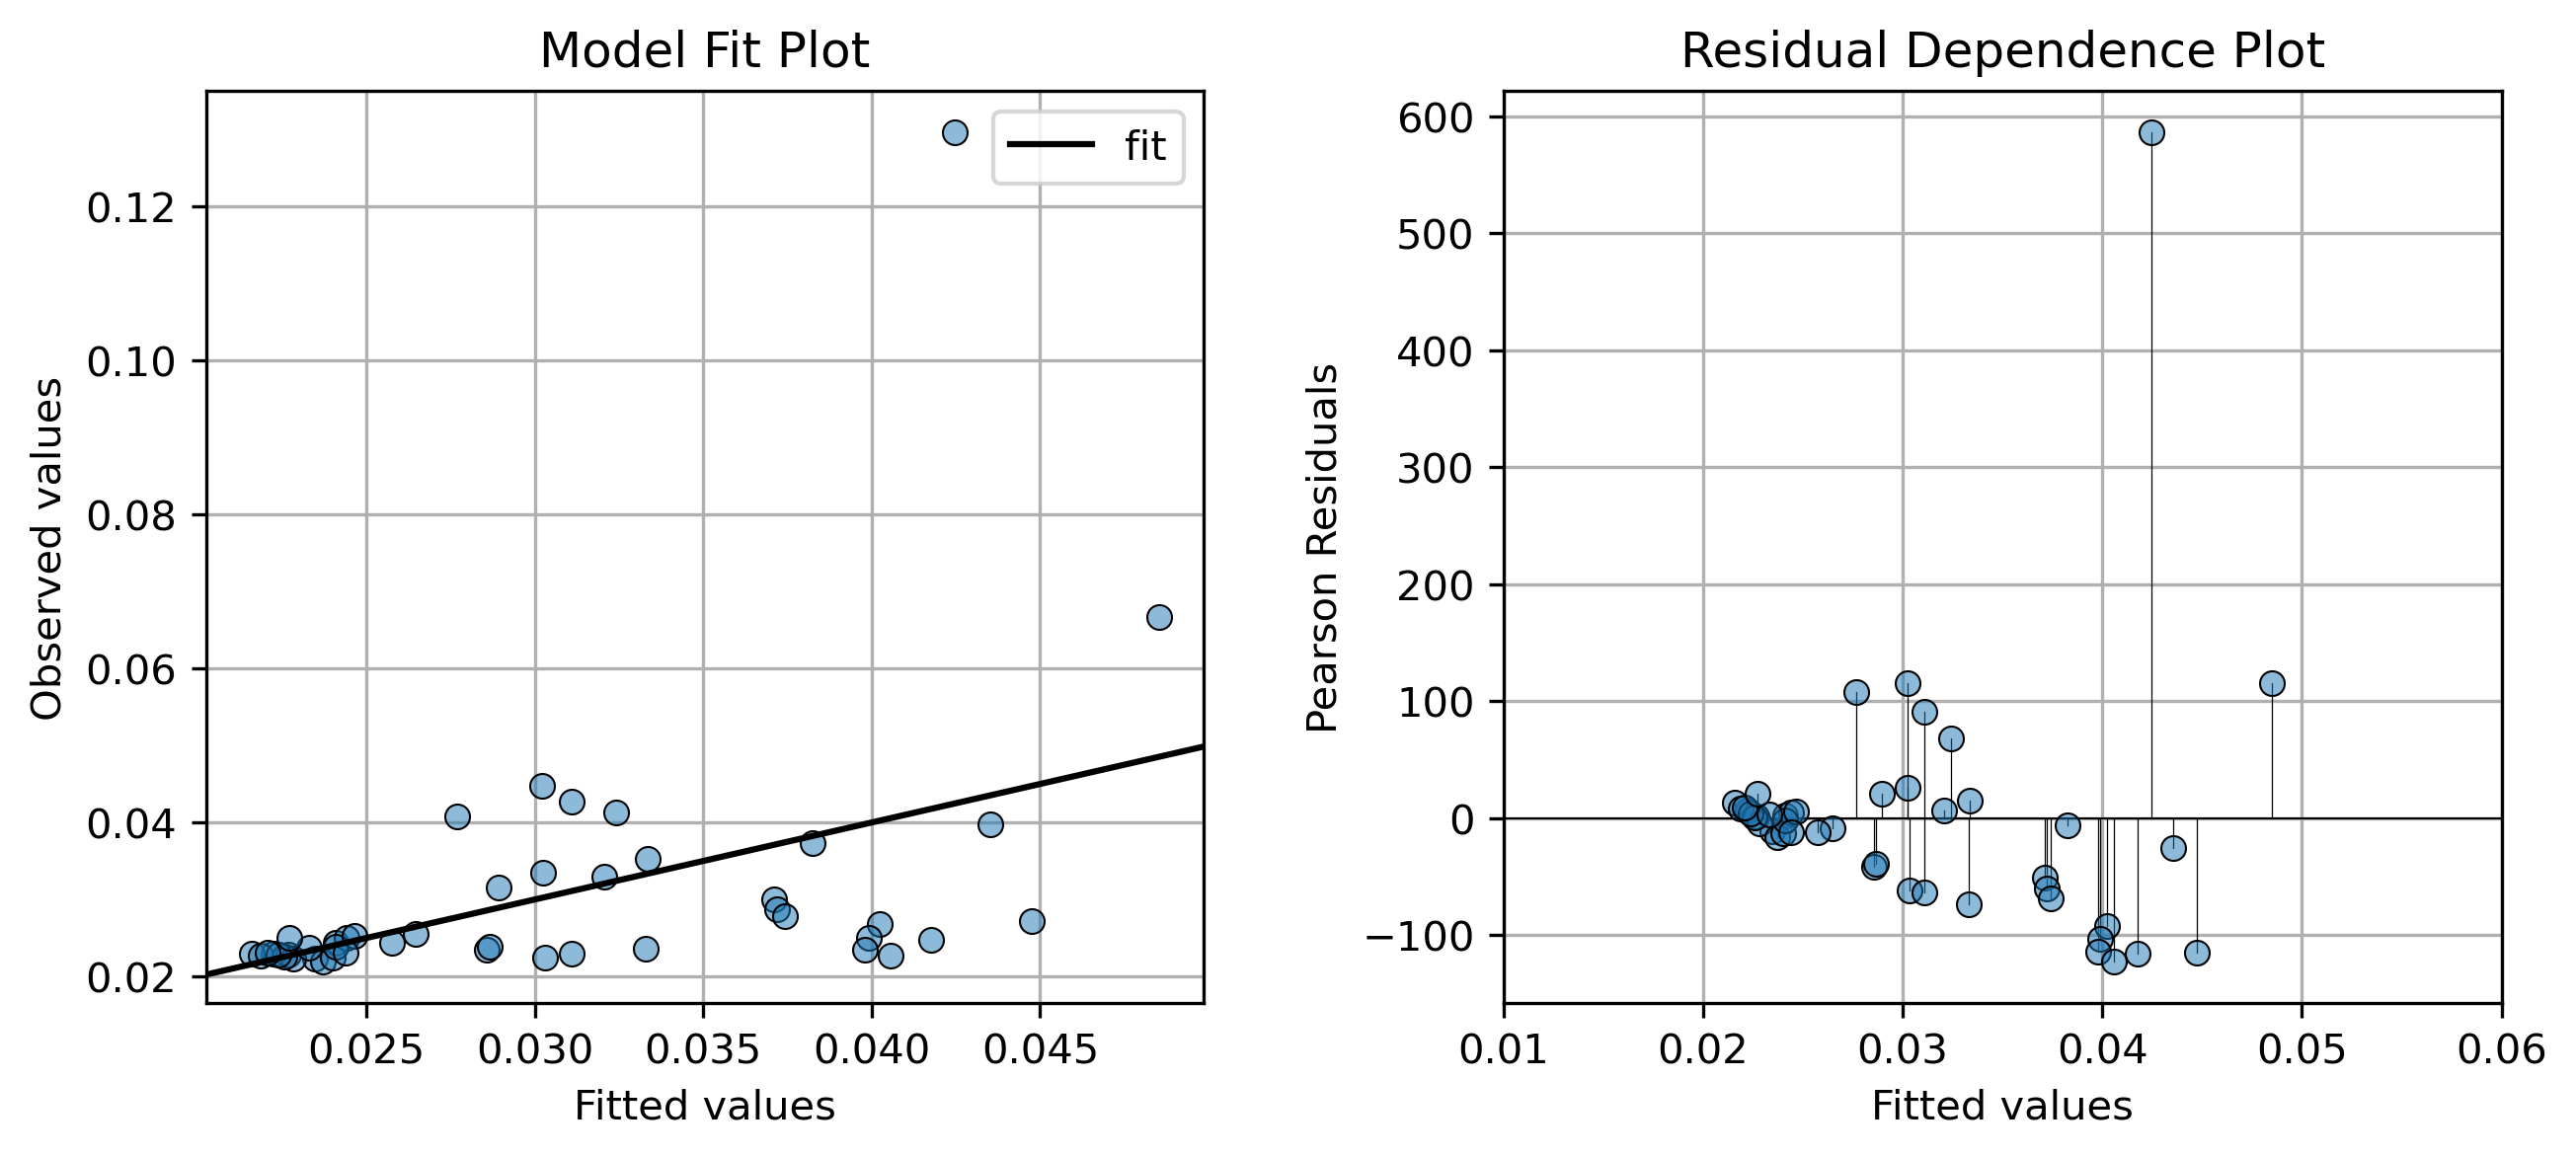

In [26]:
res = do_model('successes+failures ~ coverage + C(treatment)')

In [27]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       37
Model Family:                       Binomial   Df Model:                            8
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -1.9603e+05
Date:                       Sat, 28 Oct 2023   Deviance:                   3.9147e+05
Time:                               00:53:55   Pearson chi2:                 5.00e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.0177      0.003  -1361.581      0.000      -4.023      -4.012
C(treatment)[T.100Gy]    -0.2108      0.004    -53.965      0.000      -0.218      -0.203
C(treatment)[T.250Gy]    -0.1702      0.004    -45.708      0.000      -0.178      -0.163
C(treatment)[T.30D]      -0.0144      0.003     -4.137      0.000      -0.021      -0.008
C(treatment)[T.30H]      -0.0533      0.004    -15.188      0.000      -0.060      -0.046
C(treatment)[T.500Gy]     0.2519      0.003     76.723      0.000       0.245       0.258
C(treatment)[T.D]         0.6987      0.003    249.860      0.000       0.693       0.704
C(treatment)[T.H]         0.3876      0.003    140.195      0.000       0.382       0.393
coverage                  0.0014   8.58e-06    160.010      0.000       0.001       0.001
=========================================================================================
"""

<a id="glm4"></a>
### GLM 4 coverage + treatment + experiment

AIC:  392073.6194537061


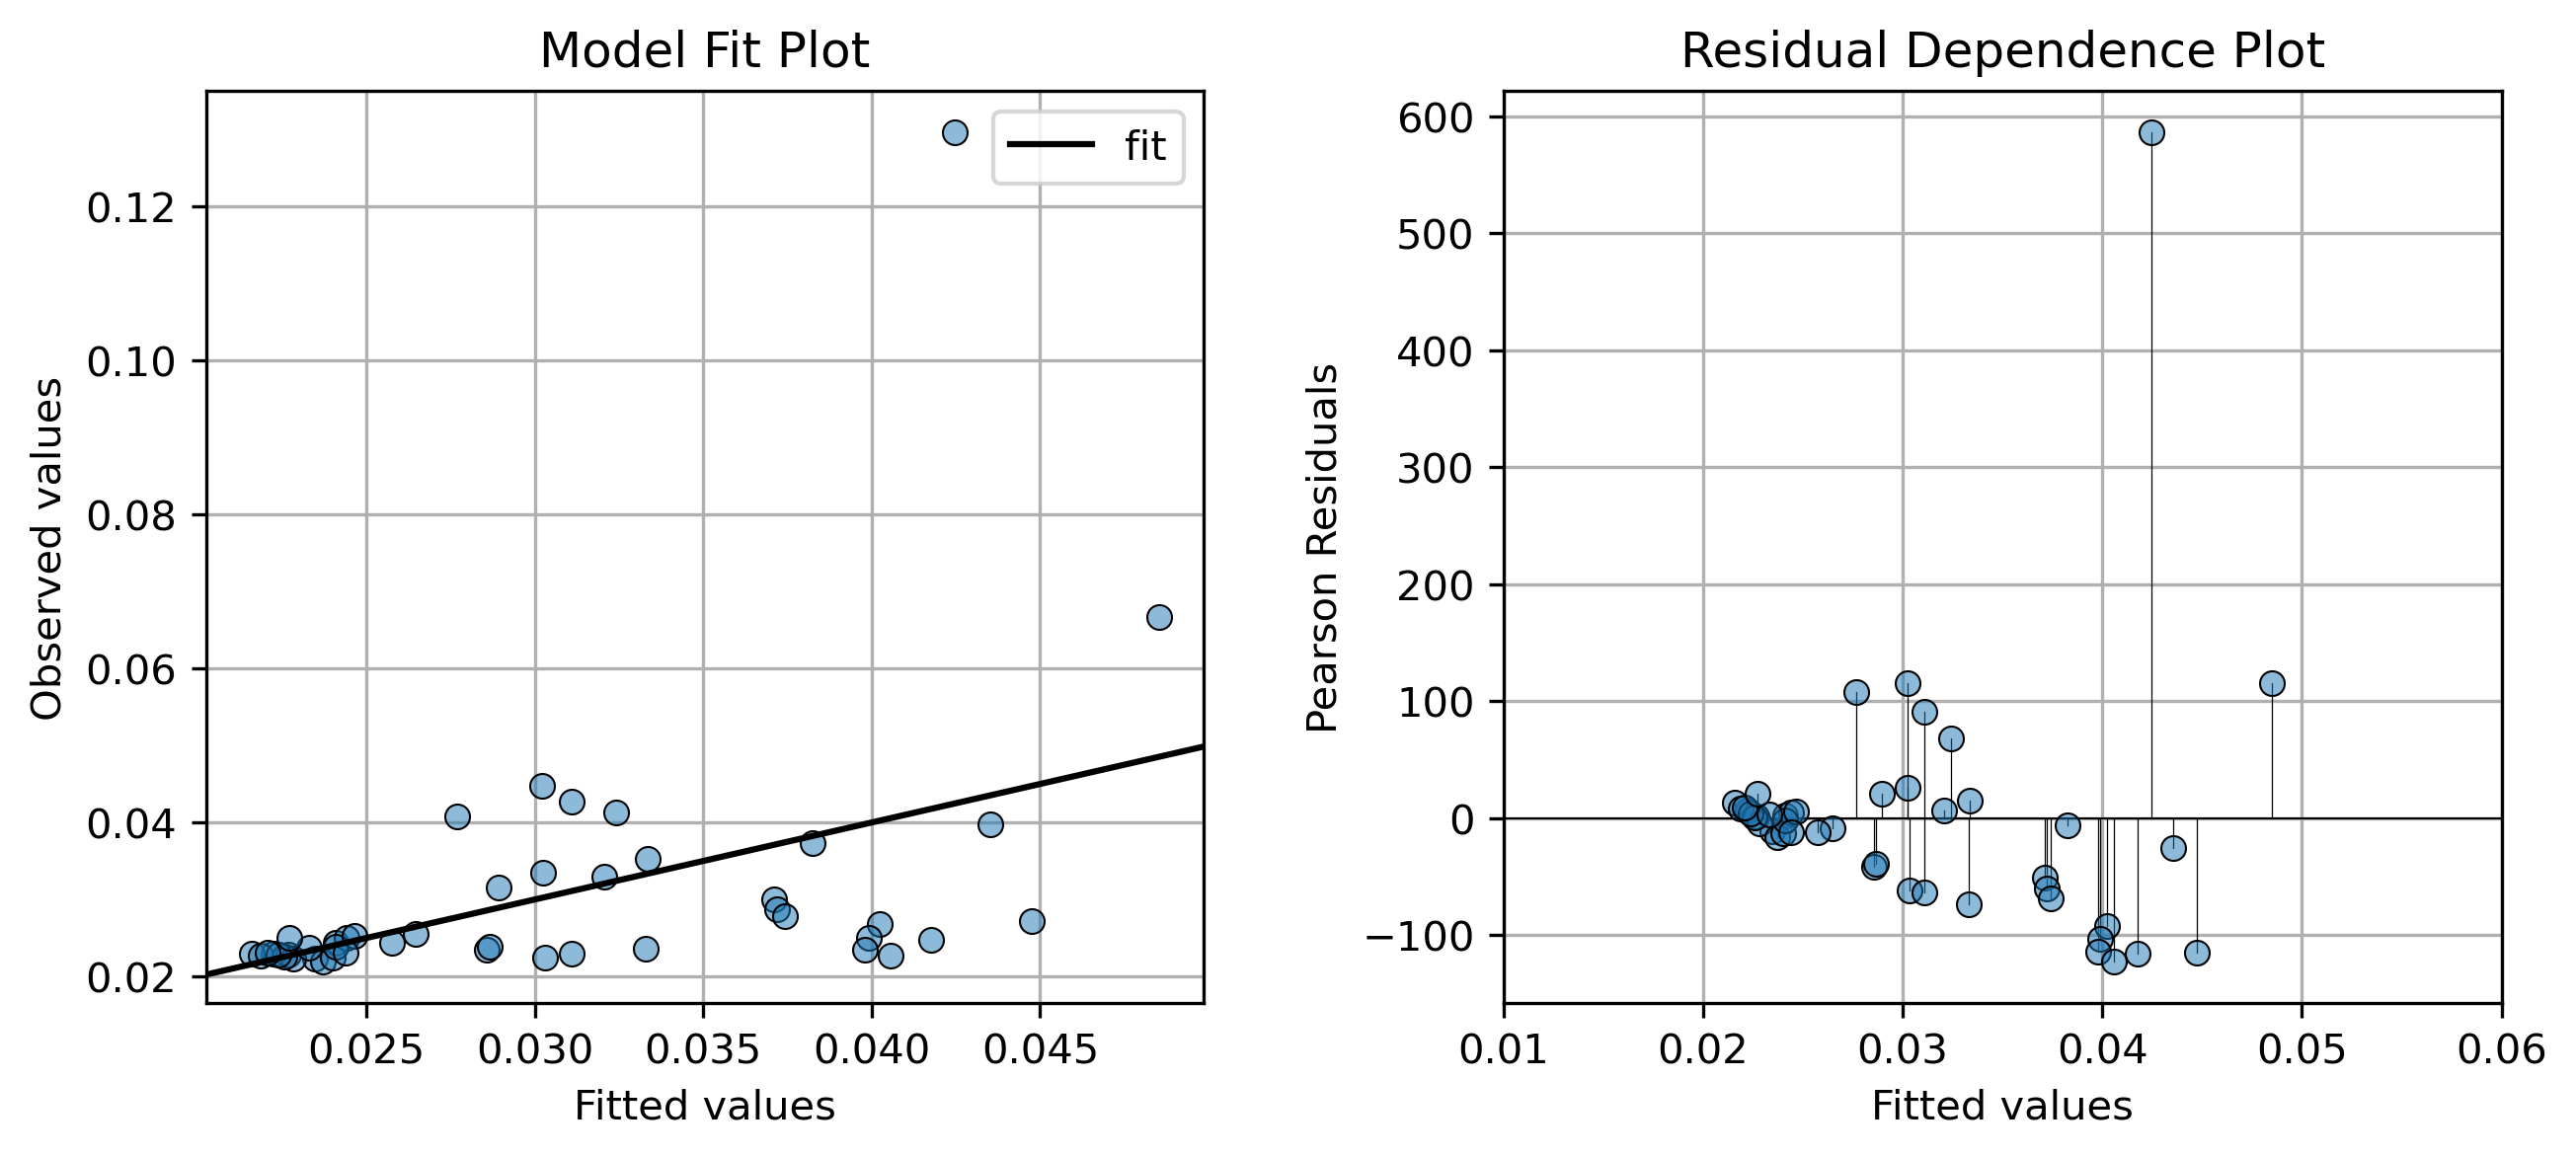

In [28]:
res = do_model('successes+failures ~ coverage + C(treatment) + C(experiment)')

In [29]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       37
Model Family:                       Binomial   Df Model:                            8
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -1.9603e+05
Date:                       Sat, 28 Oct 2023   Deviance:                   3.9147e+05
Time:                               00:53:56   Pearson chi2:                 5.00e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.0177      0.003  -1361.581      0.000      -4.023      -4.012
C(treatment)[T.100Gy]    -0.2108      0.004    -53.965      0.000      -0.218      -0.203
C(treatment)[T.250Gy]    -0.1702      0.004    -45.708      0.000      -0.178      -0.163
C(treatment)[T.30D]      -0.0144      0.003     -4.137      0.000      -0.021      -0.008
C(treatment)[T.30H]      -0.0533      0.004    -15.188      0.000      -0.060      -0.046
C(treatment)[T.500Gy]     0.2519      0.003     76.723      0.000       0.245       0.258
C(treatment)[T.D]         0.3366      0.001    263.265      0.000       0.334       0.339
C(treatment)[T.H]         0.0255      0.001     20.306      0.000       0.023       0.028
C(experiment)[T.ME]       0.3621      0.002    206.893      0.000       0.359       0.366
coverage                  0.0014   8.58e-06    160.010      0.000       0.001       0.001
=========================================================================================
"""

<a id="glm5"></a>
### GLM 5 coverage + treatment + cov:treat

AIC:  301149.7231851615


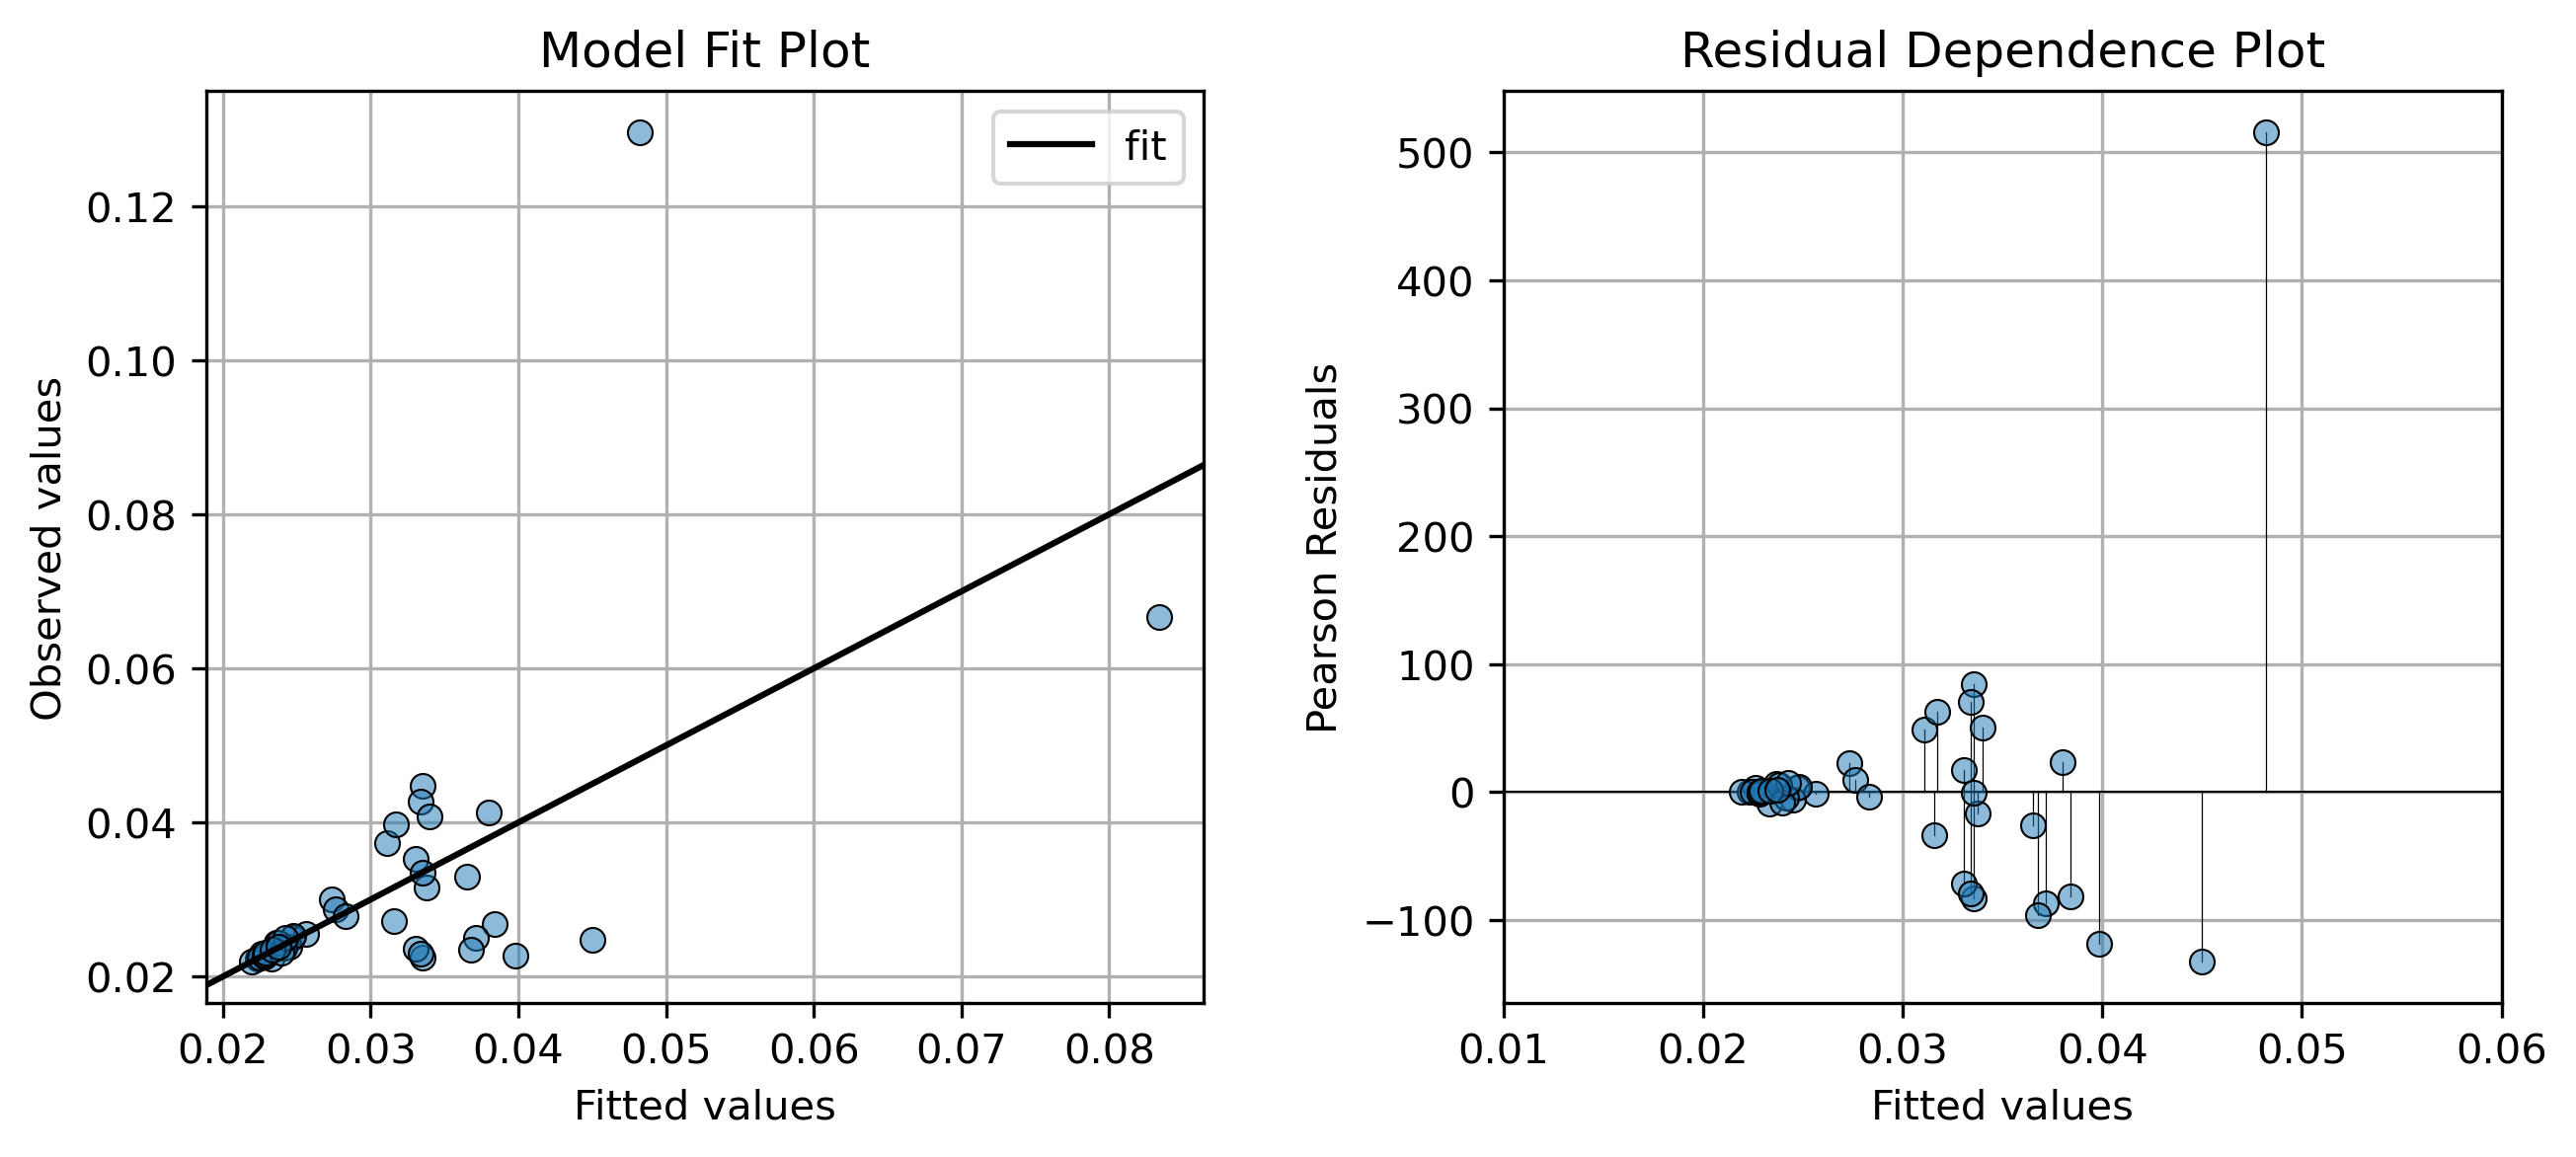

In [30]:
res = do_model('successes+failures ~ coverage + C(treatment) + coverage:C(treatment)')

In [31]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       30
Model Family:                       Binomial   Df Model:                           15
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -1.5056e+05
Date:                       Sat, 28 Oct 2023   Deviance:                   3.0054e+05
Time:                               00:53:57   Pearson chi2:                 3.71e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -3.7003      0.020   -189.475      0.000      -3.739      -3.662
C(treatment)[T.100Gy]             -0.2342      0.040     -5.799      0.000      -0.313      -0.155
C(treatment)[T.250Gy]              0.0695      0.031      2.256      0.024       0.009       0.130
C(treatment)[T.30D]               -0.2001      0.030     -6.709      0.000      -0.259      -0.142
C(treatment)[T.30H]                0.0750      0.028      2.699      0.007       0.021       0.129
C(treatment)[T.500Gy]             -0.9534      0.023    -42.079      0.000      -0.998      -0.909
C(treatment)[T.D]                 -0.1354      0.020     -6.883      0.000      -0.174      -0.097
C(treatment)[T.H]                  0.3649      0.020     18.553      0.000       0.326       0.403
coverage                          -0.0003      0.000     -3.069      0.002      -0.001      -0.000
coverage:C(treatment)[T.100Gy]     0.0010      0.000      7.215      0.000       0.001       0.001
coverage:C(treatment)[T.250Gy]     0.0001      0.000      0.897      0.370      -0.000       0.000
coverage:C(treatment)[T.30D]       0.0011      0.000      7.175      0.000       0.001       0.001
coverage:C(treatment)[T.30H]      -0.0004      0.000     -2.571      0.010      -0.001   -8.38e-05
coverage:C(treatment)[T.500Gy]     0.0056      0.000     48.983      0.000       0.005       0.006
coverage:C(treatment)[T.D]         0.0061      0.000     57.954      0.000       0.006       0.006
coverage:C(treatment)[T.H]         0.0001      0.000      1.010      0.313   -9.88e-05       0.000
==================================================================================================
"""

<a id="glm6"></a>
### GLM 6 coverage

AIC:  537609.2238401175


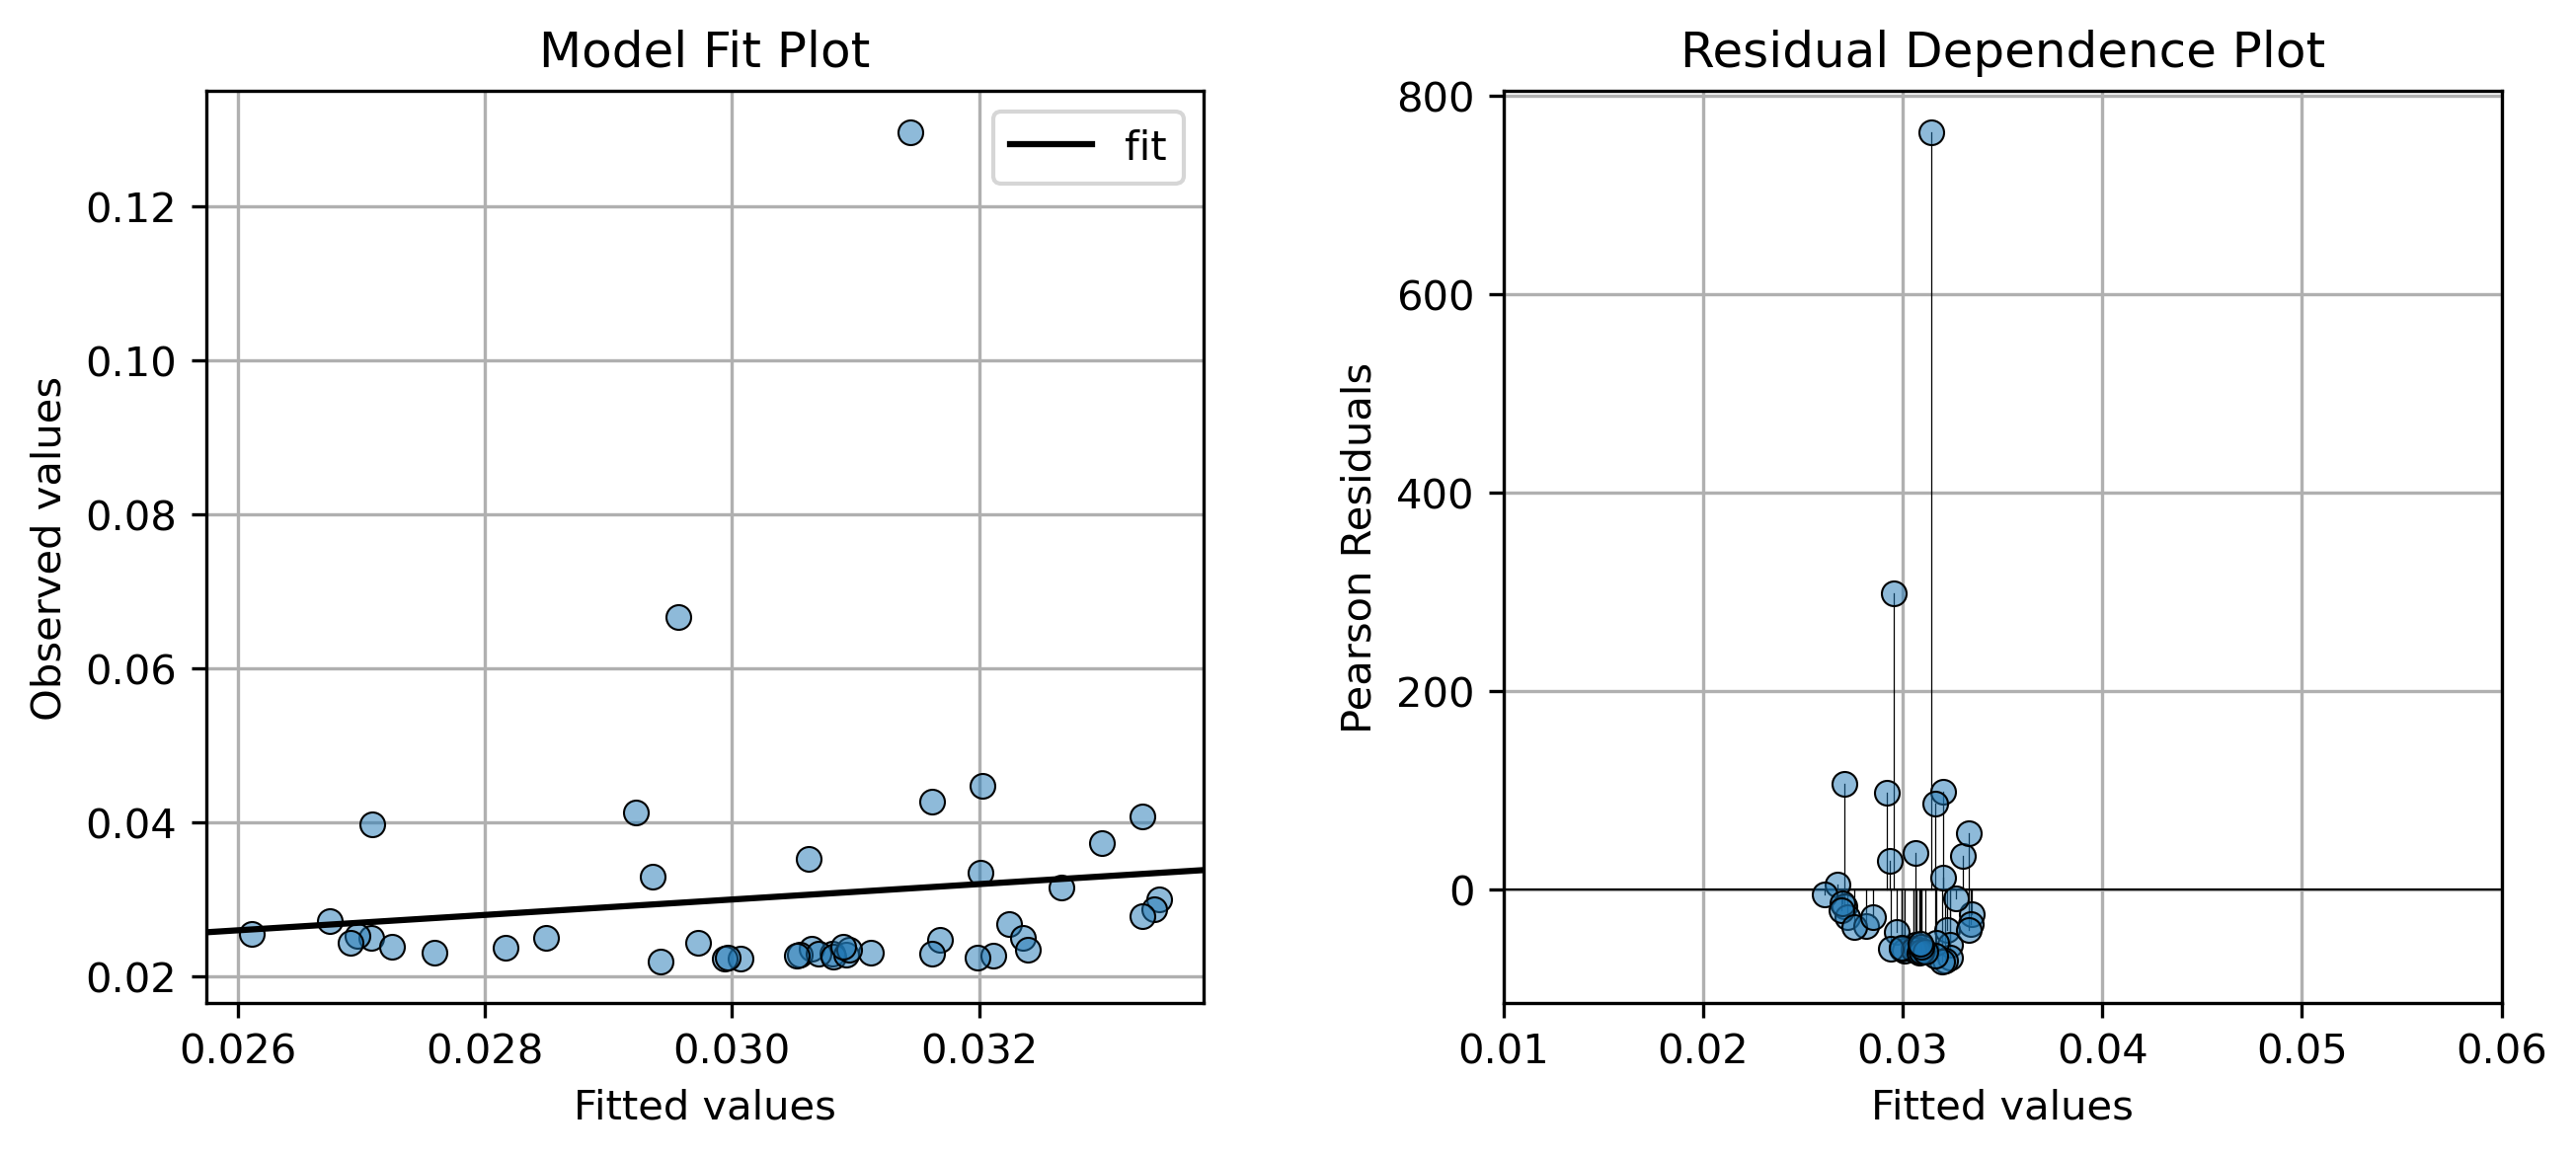

In [32]:
res = do_model('successes+failures ~ coverage')

In [33]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       44
Model Family:                       Binomial   Df Model:                            1
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -2.6880e+05
Date:                       Sat, 28 Oct 2023   Deviance:                   5.3702e+05
Time:                               00:53:58   Pearson chi2:                 8.05e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3349      0.001  -2525.651      0.000      -3.337      -3.332
coverage      -0.0006    5.8e-06   -107.883      0.000      -0.001      -0.001
==============================================================================
"""

<a id="glm7"></a>
### GLM 7 treatment

AIC:  416642.81670557946


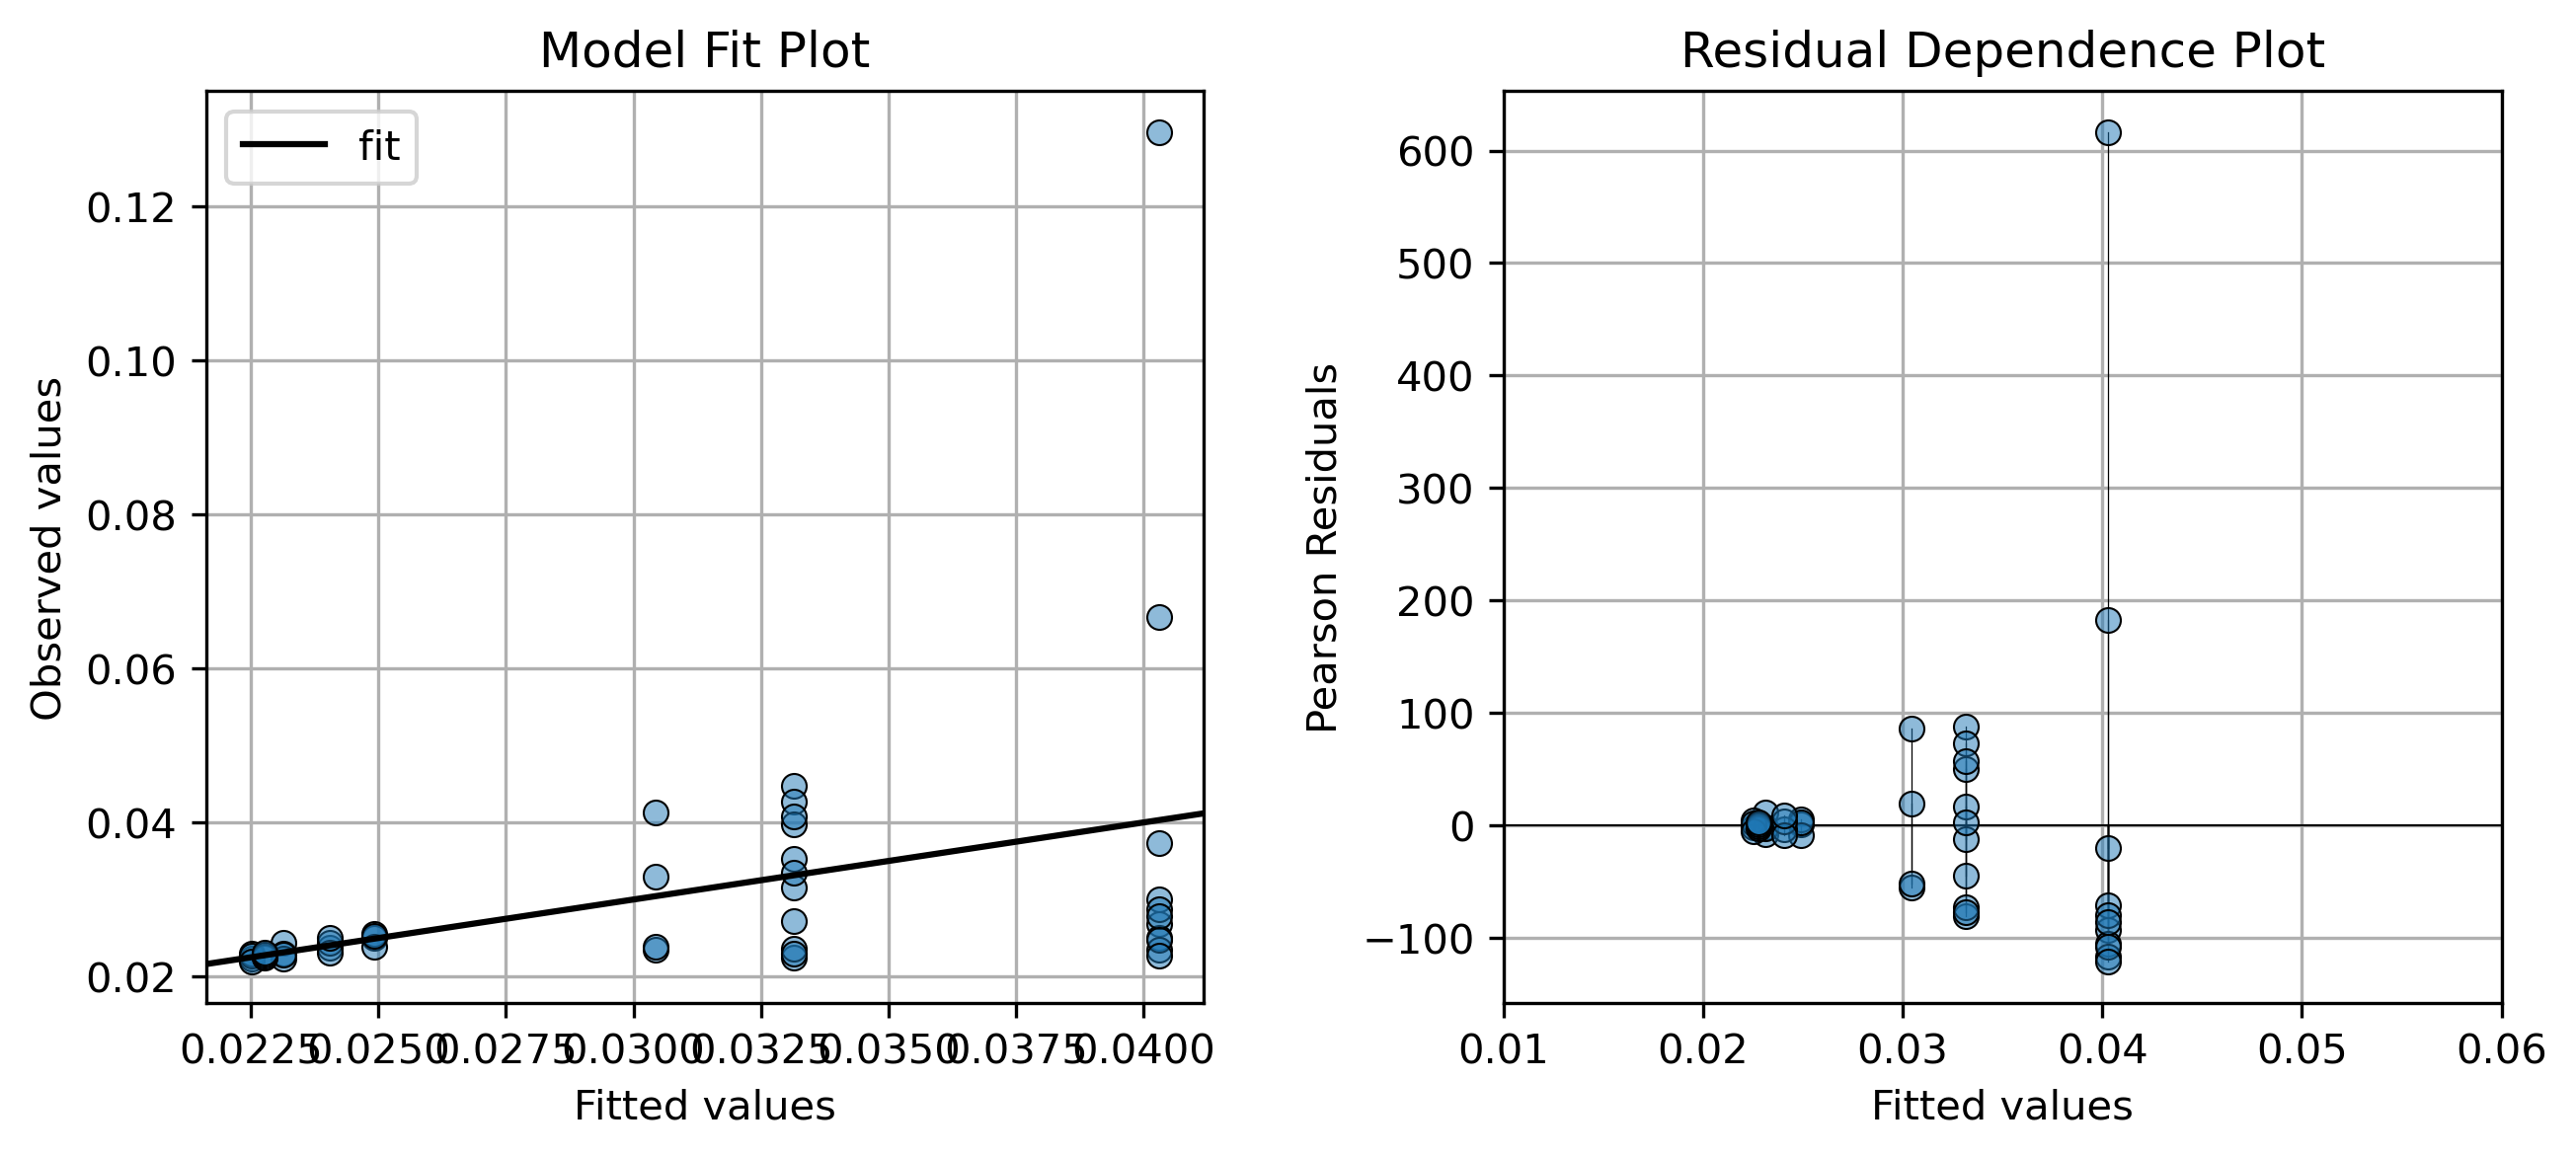

In [34]:
res = do_model('successes+failures ~ C(treatment)')

In [35]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       38
Model Family:                       Binomial   Df Model:                            7
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -2.0831e+05
Date:                       Sat, 28 Oct 2023   Deviance:                   4.1604e+05
Time:                               00:54:00   Pearson chi2:                 5.45e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.7598      0.002  -1522.520      0.000      -3.765      -3.755
C(treatment)[T.100Gy]     0.0926      0.003     27.138      0.000       0.086       0.099
C(treatment)[T.250Gy]     0.0562      0.003     16.337      0.000       0.049       0.063
C(treatment)[T.30D]       0.0166      0.003      4.765      0.000       0.010       0.023
C(treatment)[T.30H]      -0.0114      0.004     -3.255      0.001      -0.018      -0.005
C(treatment)[T.500Gy]     0.2985      0.003     91.309      0.000       0.292       0.305
C(treatment)[T.D]         0.5895      0.003    217.097      0.000       0.584       0.595
C(treatment)[T.H]         0.3867      0.003    139.930      0.000       0.381       0.392
=========================================================================================
"""

<a id="glm8"></a>
### GLM 8 cov + treat + exp + gen + seq + cov:treat + exp:gen + cov:seq

AIC:  117051.79373080081


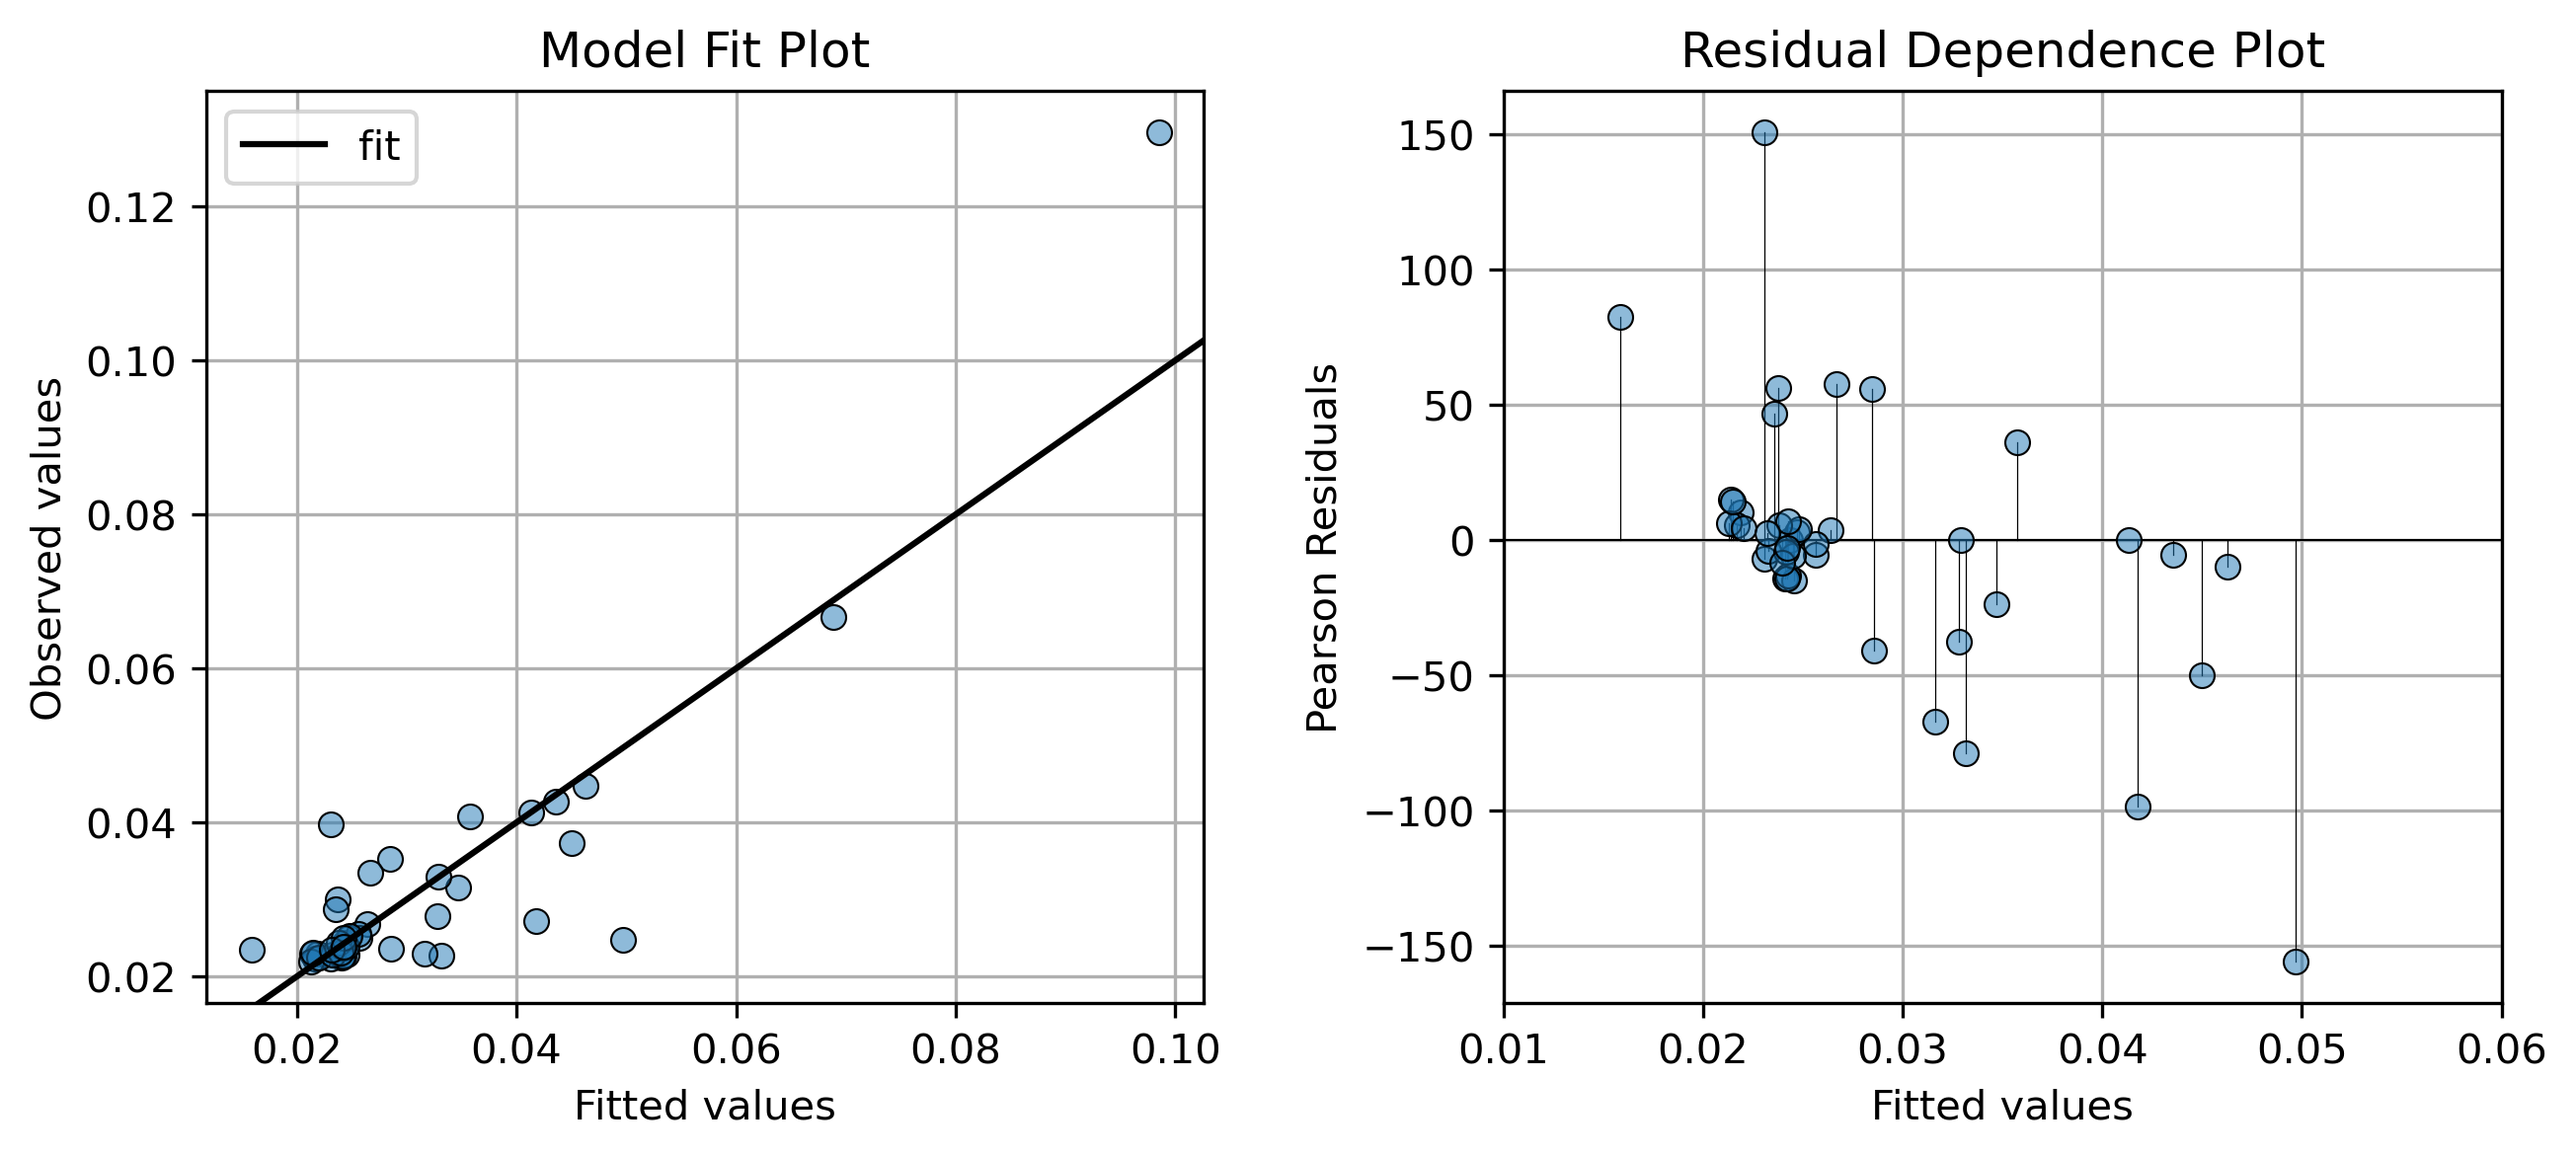

In [36]:
res = do_model('successes+failures ~ coverage + C(treatment) + C(experiment) + generations + C(sequencing_run) + coverage:C(treatment) + C(experiment):generations + coverage:C(sequencing_run)')

In [37]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       21
Model Family:                       Binomial   Df Model:                           24
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -58501.
Date:                       Sat, 28 Oct 2023   Deviance:                   1.1642e+05
Time:                               00:54:01   Pearson chi2:                 1.16e+05
No. Iterations:                          100   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -0.1432      0.082     -1.742      0.082      -0.304       0.018
C(treatment)[T.100Gy]                        -0.9534      0.046    -20.656      0.000      -1.044      -0.863
C(treatment)[T.250Gy]                        -0.6498      0.044    -14.893      0.000      -0.735      -0.564
C(treatment)[T.30D]                          -0.2791      0.044     -6.344      0.000      -0.365      -0.193
C(treatment)[T.30H]                          -1.2182      0.030    -40.966      0.000      -1.276      -1.160
C(treatment)[T.500Gy]                        -1.3765      0.025    -54.928      0.000      -1.426      -1.327
C(treatment)[T.D]                            -2.3433      0.012   -196.130      0.000      -2.367      -2.320
C(treatment)[T.H]                             4.6220      0.020    230.705      0.000       4.583       4.661
C(experiment)[T.ME]                           2.2788      0.026     87.053      0.000       2.227       2.330
C(sequencing_run)[T.GC078]                   -0.4726      0.104     -4.545      0.000      -0.676      -0.269
C(sequencing_run)[T.GC078+GC100]            -15.4628      0.112   -137.700      0.000     -15.683     -15.243
C(sequencing_run)[T.GC087]                   -3.6599      0.107    -34.314      0.000      -3.869      -3.451
C(sequencing_run)[T.GC100]                   -1.6032      0.079    -20.279      0.000      -1.758      -1.448
C(sequencing_run)[T.GC114]                   -3.5296      0.104    -33.943      0.000      -3.733      -3.326
coverage                                     -0.0094      0.000    -20.555      0.000      -0.010      -0.009
coverage:C(treatment)[T.100Gy]                0.0036      0.000     22.122      0.000       0.003       0.004
coverage:C(treatment)[T.250Gy]                0.0028      0.000     17.195      0.000       0.002       0.003
coverage:C(treatment)[T.30D]                  0.0010      0.000      4.366      0.000       0.001       0.001
coverage:C(treatment)[T.30H]                  0.0056      0.000     38.650      0.000       0.005       0.006
coverage:C(treatment)[T.500Gy]                0.0079      0.000     61.246      0.000       0.008       0.008
coverage:C(treatment)[T.D]                    0.0311      0.000    135.807      0.000       0.031       0.032
coverage:C(treatment)[T.H]                   -0.0104      0.000    -47.855      0.000      -0.011      -0.010
coverage:C(sequencing_run)[T.GC078]           0.0009      0.000      2.178      0.029    8.65e-05       0.002
coverage:C(sequencing_run)[T.GC078+GC100]     0.0466      0.000    113.192      0.000       0.046       0.047
coverage:C(sequencing_run)[T.GC087] 

<a id="glm9"></a>
### GLM 9 cov + treat + exp + gen + seqrun + cov:treat + cov:seqrun

AIC:  117051.79371967944


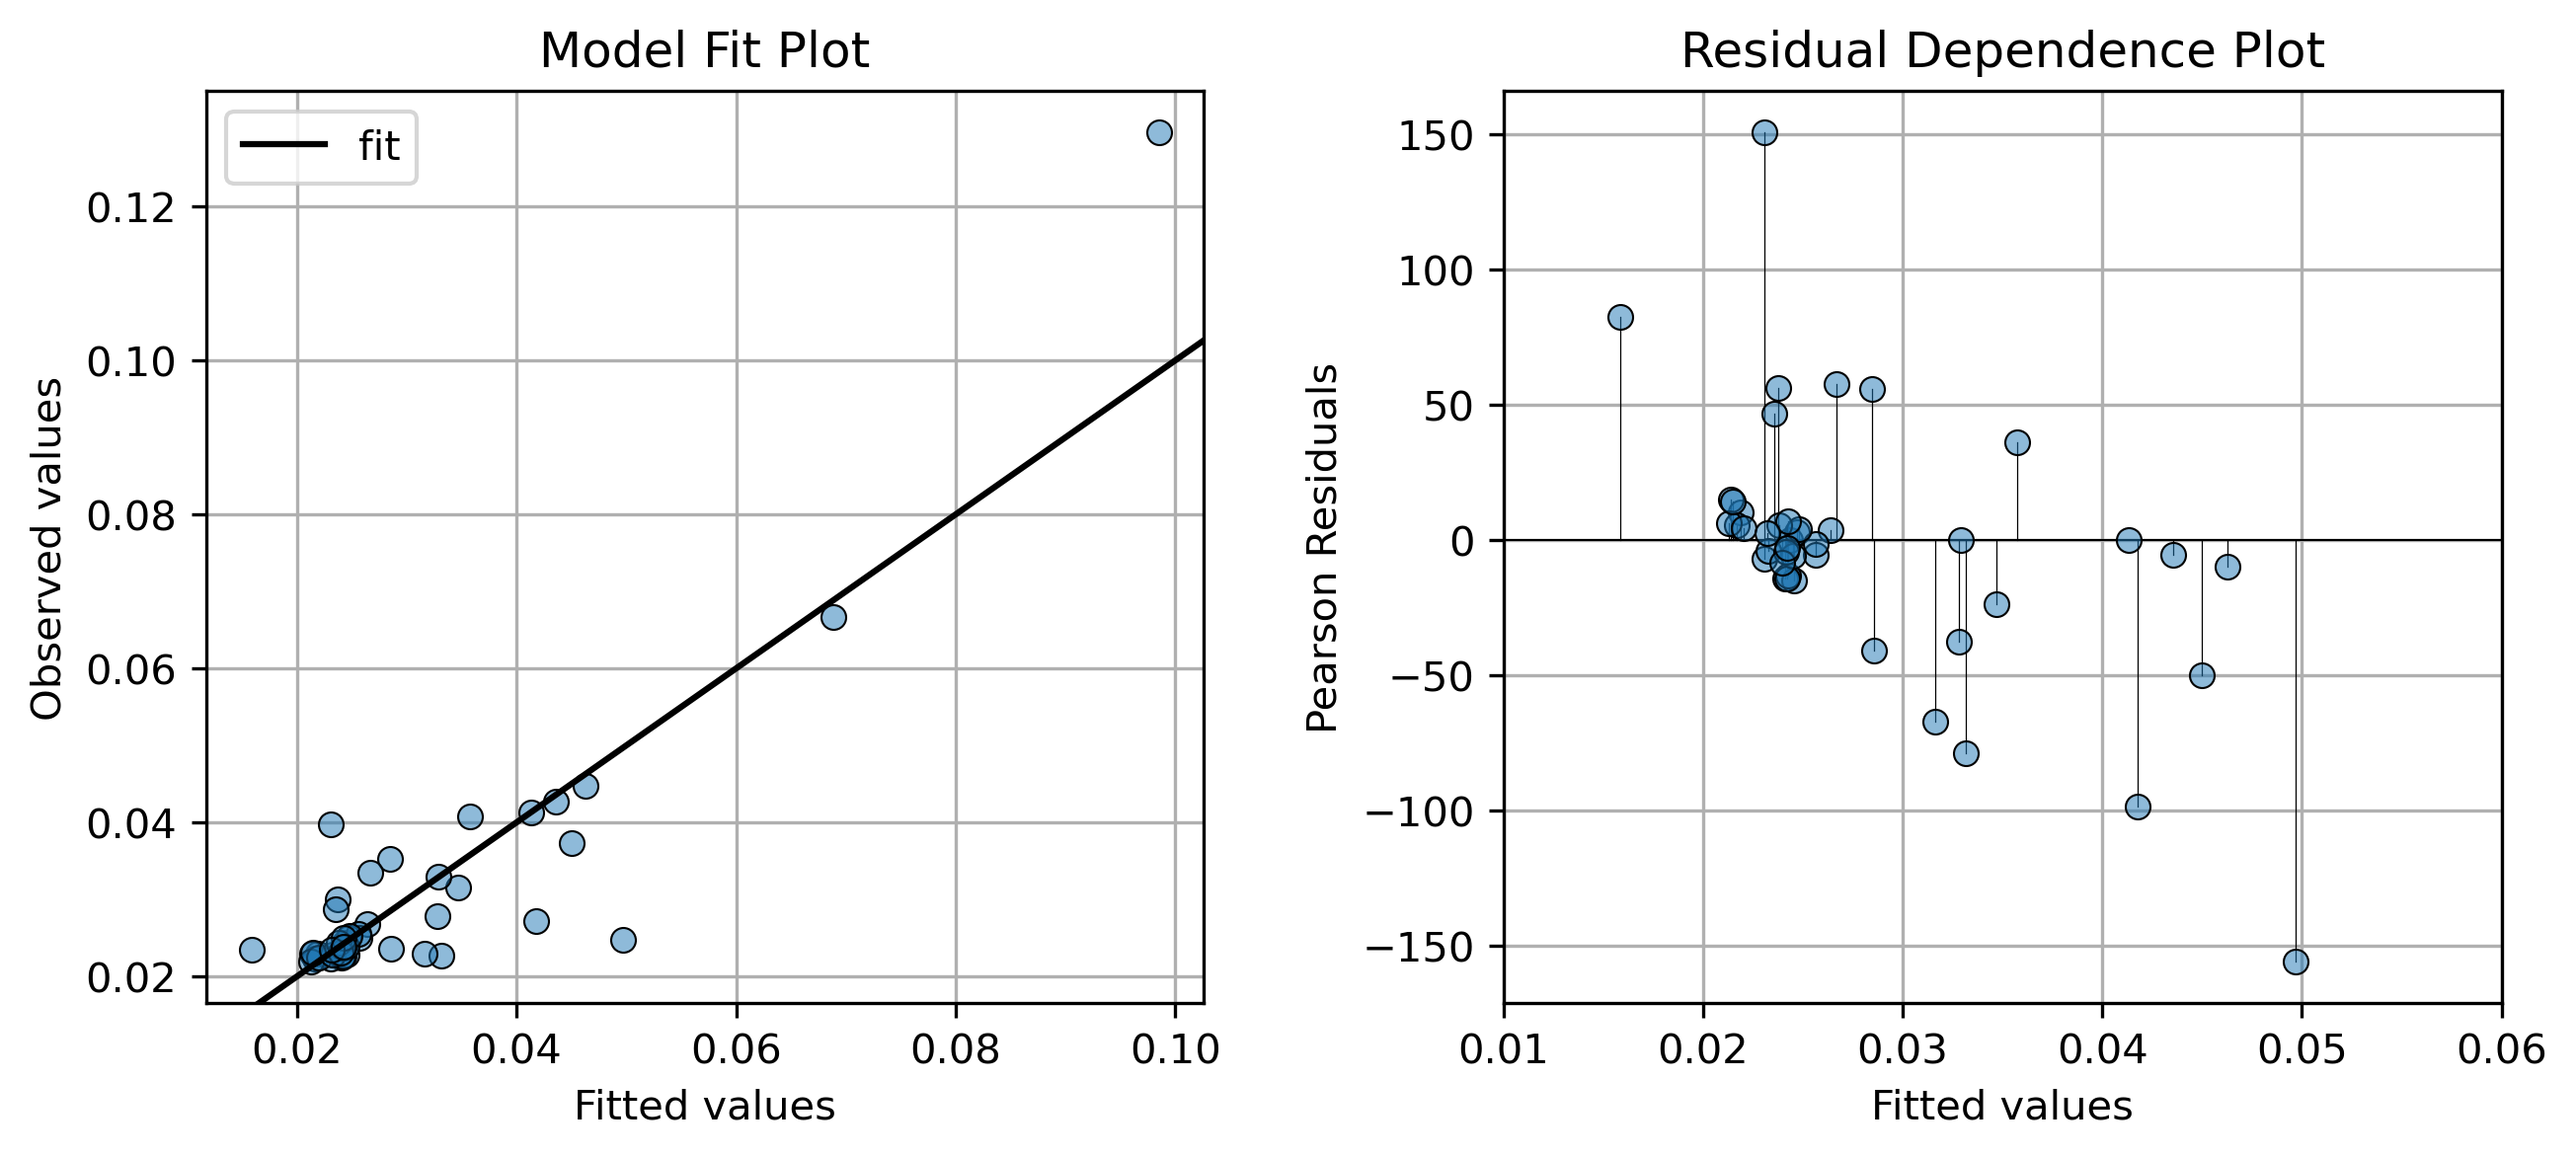

In [38]:
res = do_model('successes+failures ~ coverage + C(treatment) + C(experiment) + generations + C(sequencing_run) + coverage:C(treatment) + coverage:C(sequencing_run)')

In [39]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       21
Model Family:                       Binomial   Df Model:                           24
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -58501.
Date:                       Sat, 28 Oct 2023   Deviance:                   1.1642e+05
Time:                               00:54:02   Pearson chi2:                 1.16e+05
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -1.3305      0.117    -11.413      0.000      -1.559      -1.102
C(treatment)[T.100Gy]                        -0.9534      0.046    -20.668      0.000      -1.044      -0.863
C(treatment)[T.250Gy]                        -0.6498      0.044    -14.905      0.000      -0.735      -0.564
C(treatment)[T.30D]                          -0.2791      0.044     -6.350      0.000      -0.365      -0.193
C(treatment)[T.30H]                          -1.2182      0.030    -40.990      0.000      -1.276      -1.160
C(treatment)[T.500Gy]                        -1.3765      0.025    -54.975      0.000      -1.426      -1.327
C(treatment)[T.D]                            -1.9475      0.014   -138.153      0.000      -1.975      -1.920
C(treatment)[T.H]                             5.0178      0.021    233.660      0.000       4.976       5.060
C(experiment)[T.ME]                           3.0703      0.030    101.374      0.000       3.011       3.130
C(sequencing_run)[T.GC078]                   -0.4726      0.104     -4.548      0.000      -0.676      -0.269
C(sequencing_run)[T.GC078+GC100]            -15.4628      0.112   -137.812      0.000     -15.683     -15.243
C(sequencing_run)[T.GC087]                   -3.6599      0.107    -34.343      0.000      -3.869      -3.451
C(sequencing_run)[T.GC100]                   -1.6032      0.079    -20.294      0.000      -1.758      -1.448
C(sequencing_run)[T.GC114]                   -3.5295      0.104    -33.971      0.000      -3.733      -3.326
coverage                                     -0.0094      0.000    -20.571      0.000      -0.010      -0.009
coverage:C(treatment)[T.100Gy]                0.0036      0.000     22.138      0.000       0.003       0.004
coverage:C(treatment)[T.250Gy]                0.0028      0.000     17.209      0.000       0.002       0.003
coverage:C(treatment)[T.30D]                  0.0010      0.000      4.369      0.000       0.001       0.001
coverage:C(treatment)[T.30H]                  0.0056      0.000     38.675      0.000       0.005       0.006
coverage:C(treatment)[T.500Gy]                0.0079      0.000     61.301      0.000       0.008       0.008
coverage:C(treatment)[T.D]                    0.0311      0.000    135.902      0.000       0.031       0.032
coverage:C(treatment)[T.H]                   -0.0104      0.000    -47.887      0.000      -0.011      -0.010
coverage:C(sequencing_run)[T.GC078]           0.0009      0.000      2.180      0.029    8.71e-05       0.002
coverage:C(sequencing_run)[T.GC078+GC100]     0.0466      0.000    113.287      0.000       0.046       0.047
coverage:C(sequencing_run)[T.GC087] 

<a id="glm10"></a>
### GLM 10 cov + treat + gen + seqrun + cov:treat + cov:seqrun + gen:treat

AIC:  112013.08499500425


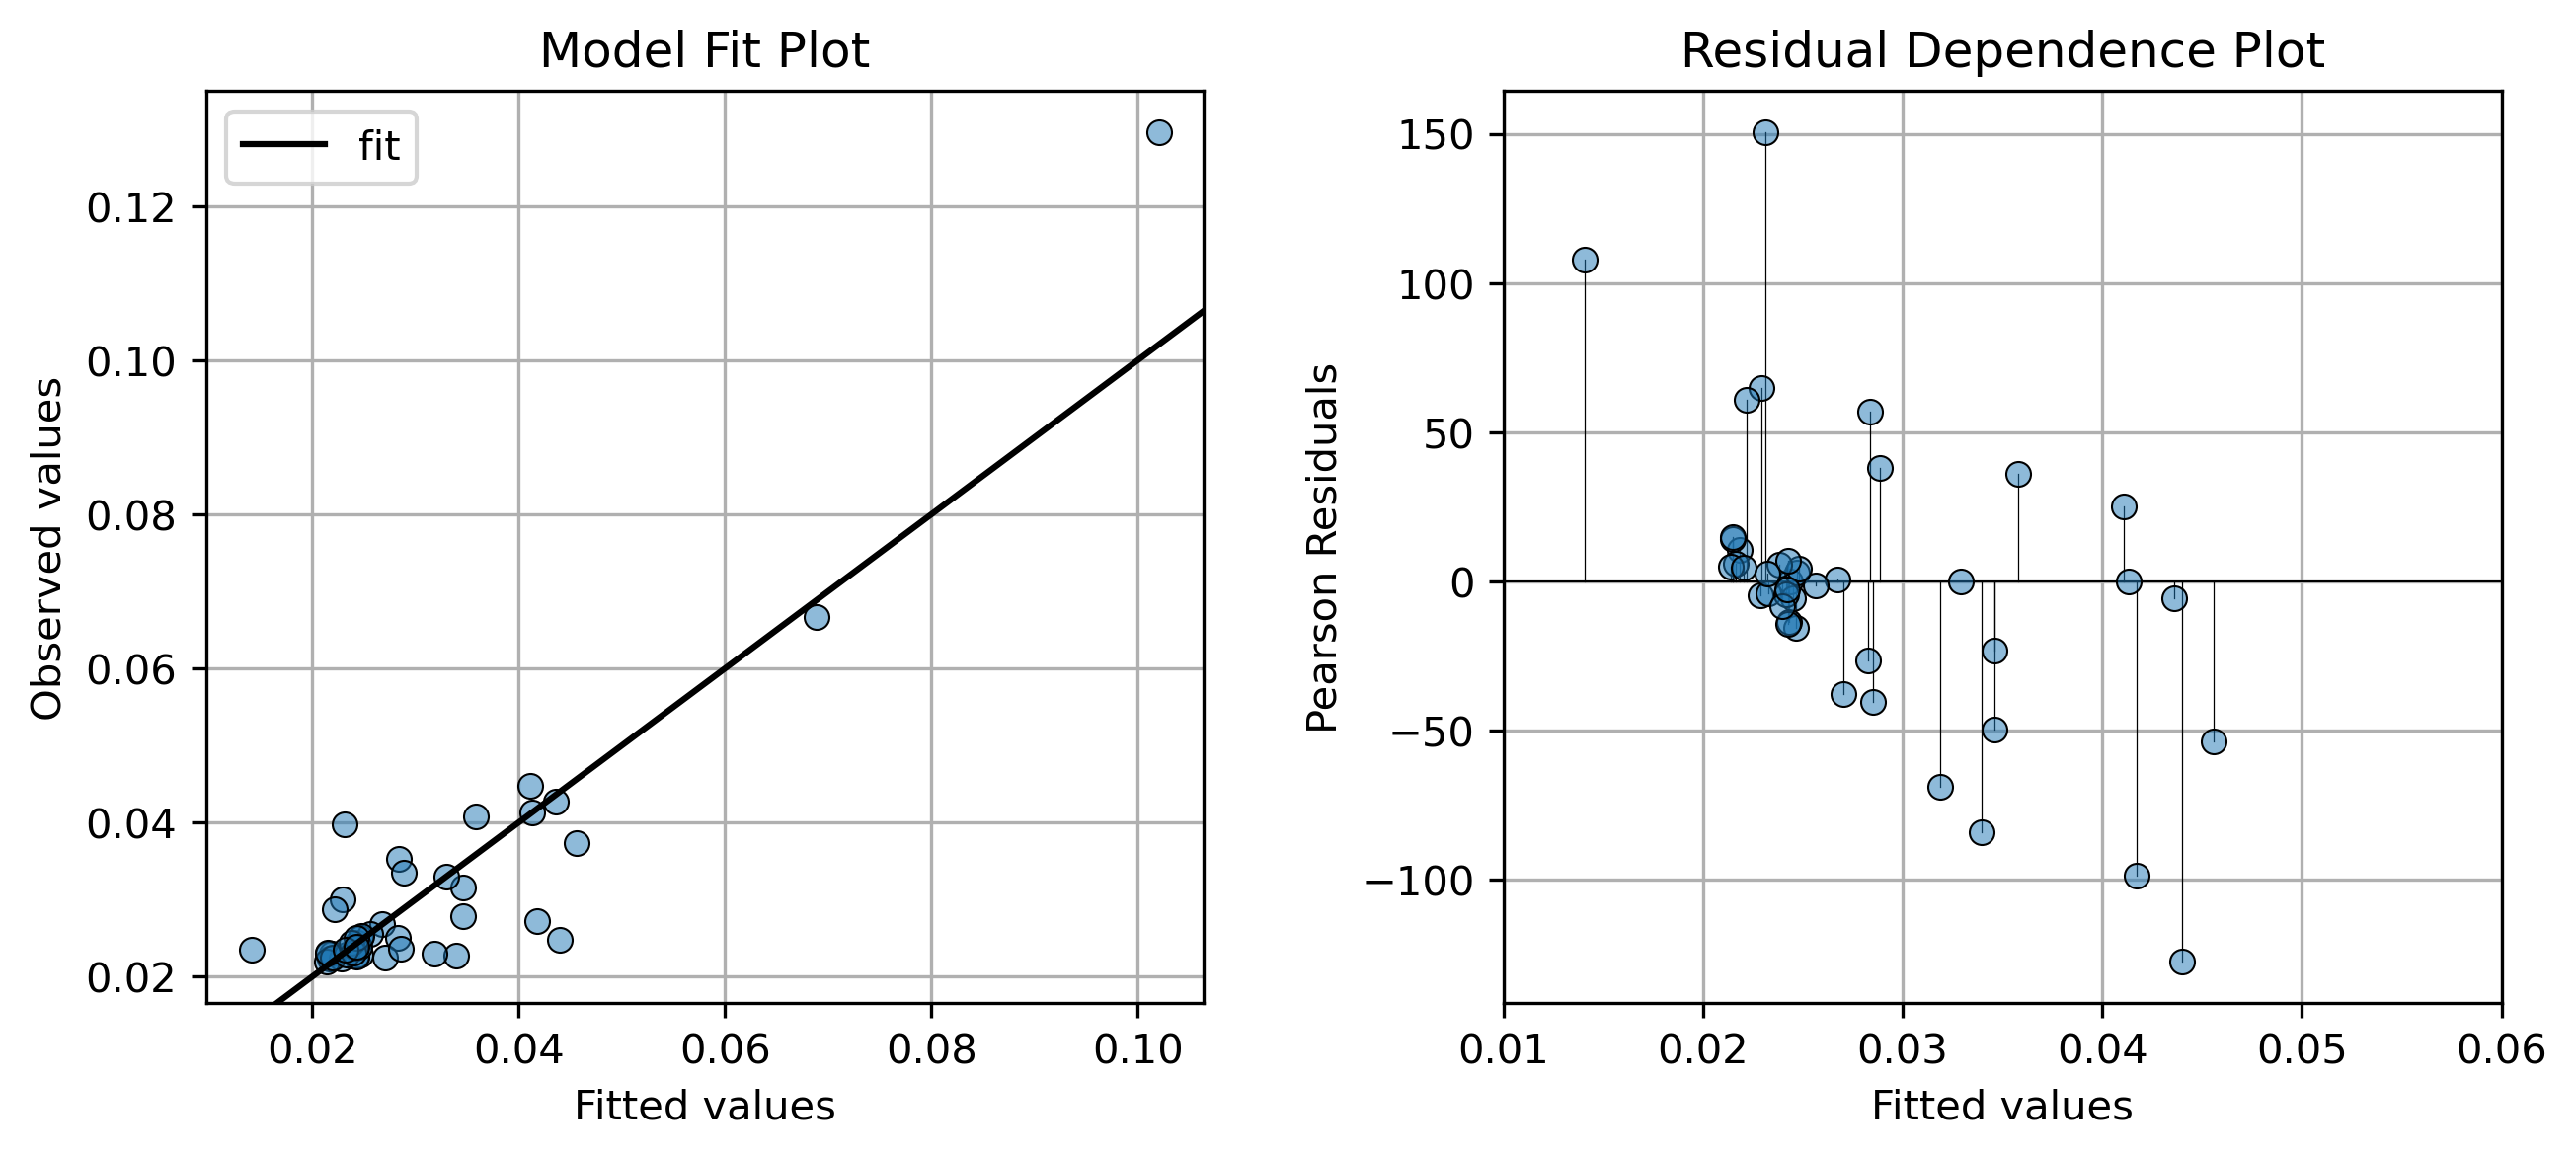

In [40]:
res = do_model('successes+failures ~ coverage + C(treatment) + C(sequencing_run) + generations + coverage:C(treatment) + coverage:C(sequencing_run) + generations:C(treatment)')

In [41]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       20
Model Family:                       Binomial   Df Model:                           25
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -55981.
Date:                       Sat, 28 Oct 2023   Deviance:                   1.1138e+05
Time:                               00:54:04   Pearson chi2:                 1.13e+05
No. Iterations:                          100   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.2112      0.093      2.273      0.023       0.029       0.393
C(treatment)[T.100Gy]                        -0.5881      0.032    -18.268      0.000      -0.651      -0.525
C(treatment)[T.250Gy]                        -0.4363      0.031    -14.146      0.000      -0.497      -0.376
C(treatment)[T.30D]                          -0.1607      0.022     -7.308      0.000      -0.204      -0.118
C(treatment)[T.30H]                          -0.5831      0.015    -39.247      0.000      -0.612      -0.554
C(treatment)[T.500Gy]                        -0.6588      0.013    -52.563      0.000      -0.683      -0.634
C(treatment)[T.D]                             1.5096      0.040     37.897      0.000       1.432       1.588
C(treatment)[T.H]                             4.4349      0.045     98.676      0.000       4.347       4.523
C(sequencing_run)[T.GC078]                   -0.3197      0.104     -3.075      0.002      -0.523      -0.116
C(sequencing_run)[T.GC078+GC100]            -15.6331      0.112   -139.348      0.000     -15.853     -15.413
C(sequencing_run)[T.GC087]                   -3.3386      0.107    -31.274      0.000      -3.548      -3.129
C(sequencing_run)[T.GC100]                   -1.0244      0.059    -17.263      0.000      -1.141      -0.908
C(sequencing_run)[T.GC114]                   -3.7324      0.104    -35.892      0.000      -3.936      -3.529
coverage                                     -0.0080      0.000    -17.385      0.000      -0.009      -0.007
coverage:C(treatment)[T.100Gy]                0.0032      0.000     19.184      0.000       0.003       0.003
coverage:C(treatment)[T.250Gy]                0.0023      0.000     14.208      0.000       0.002       0.003
coverage:C(treatment)[T.30D]                  0.0012      0.000      5.327      0.000       0.001       0.002
coverage:C(treatment)[T.30H]                  0.0053      0.000     36.750      0.000       0.005       0.006
coverage:C(treatment)[T.500Gy]                0.0076      0.000     58.618      0.000       0.007       0.008
coverage:C(treatment)[T.D]                    0.0292      0.000    126.853      0.000       0.029       0.030
coverage:C(treatment)[T.H]                   -0.0126      0.000    -57.465      0.000      -0.013      -0.012
coverage:C(sequencing_run)[T.GC078]           0.0003      0.000      0.786      0.432      -0.000       0.001
coverage:C(sequencing_run)[T.GC078+GC100]     0.0480      0.000    116.748      0.000       0.047       0.049
coverage:C(sequencing_run)[T.GC087]           0.0156      0.000     38.167      0.000       0.015       0.016
coverage:C(sequencing_run)[T.GC100] 

<a id="glm11"></a>
### GLM 11 cov + treat + gen + seqrun + cov:treat + cov:seqrun + gen:treat + treat:seqrun

AIC:  69306.42680856833


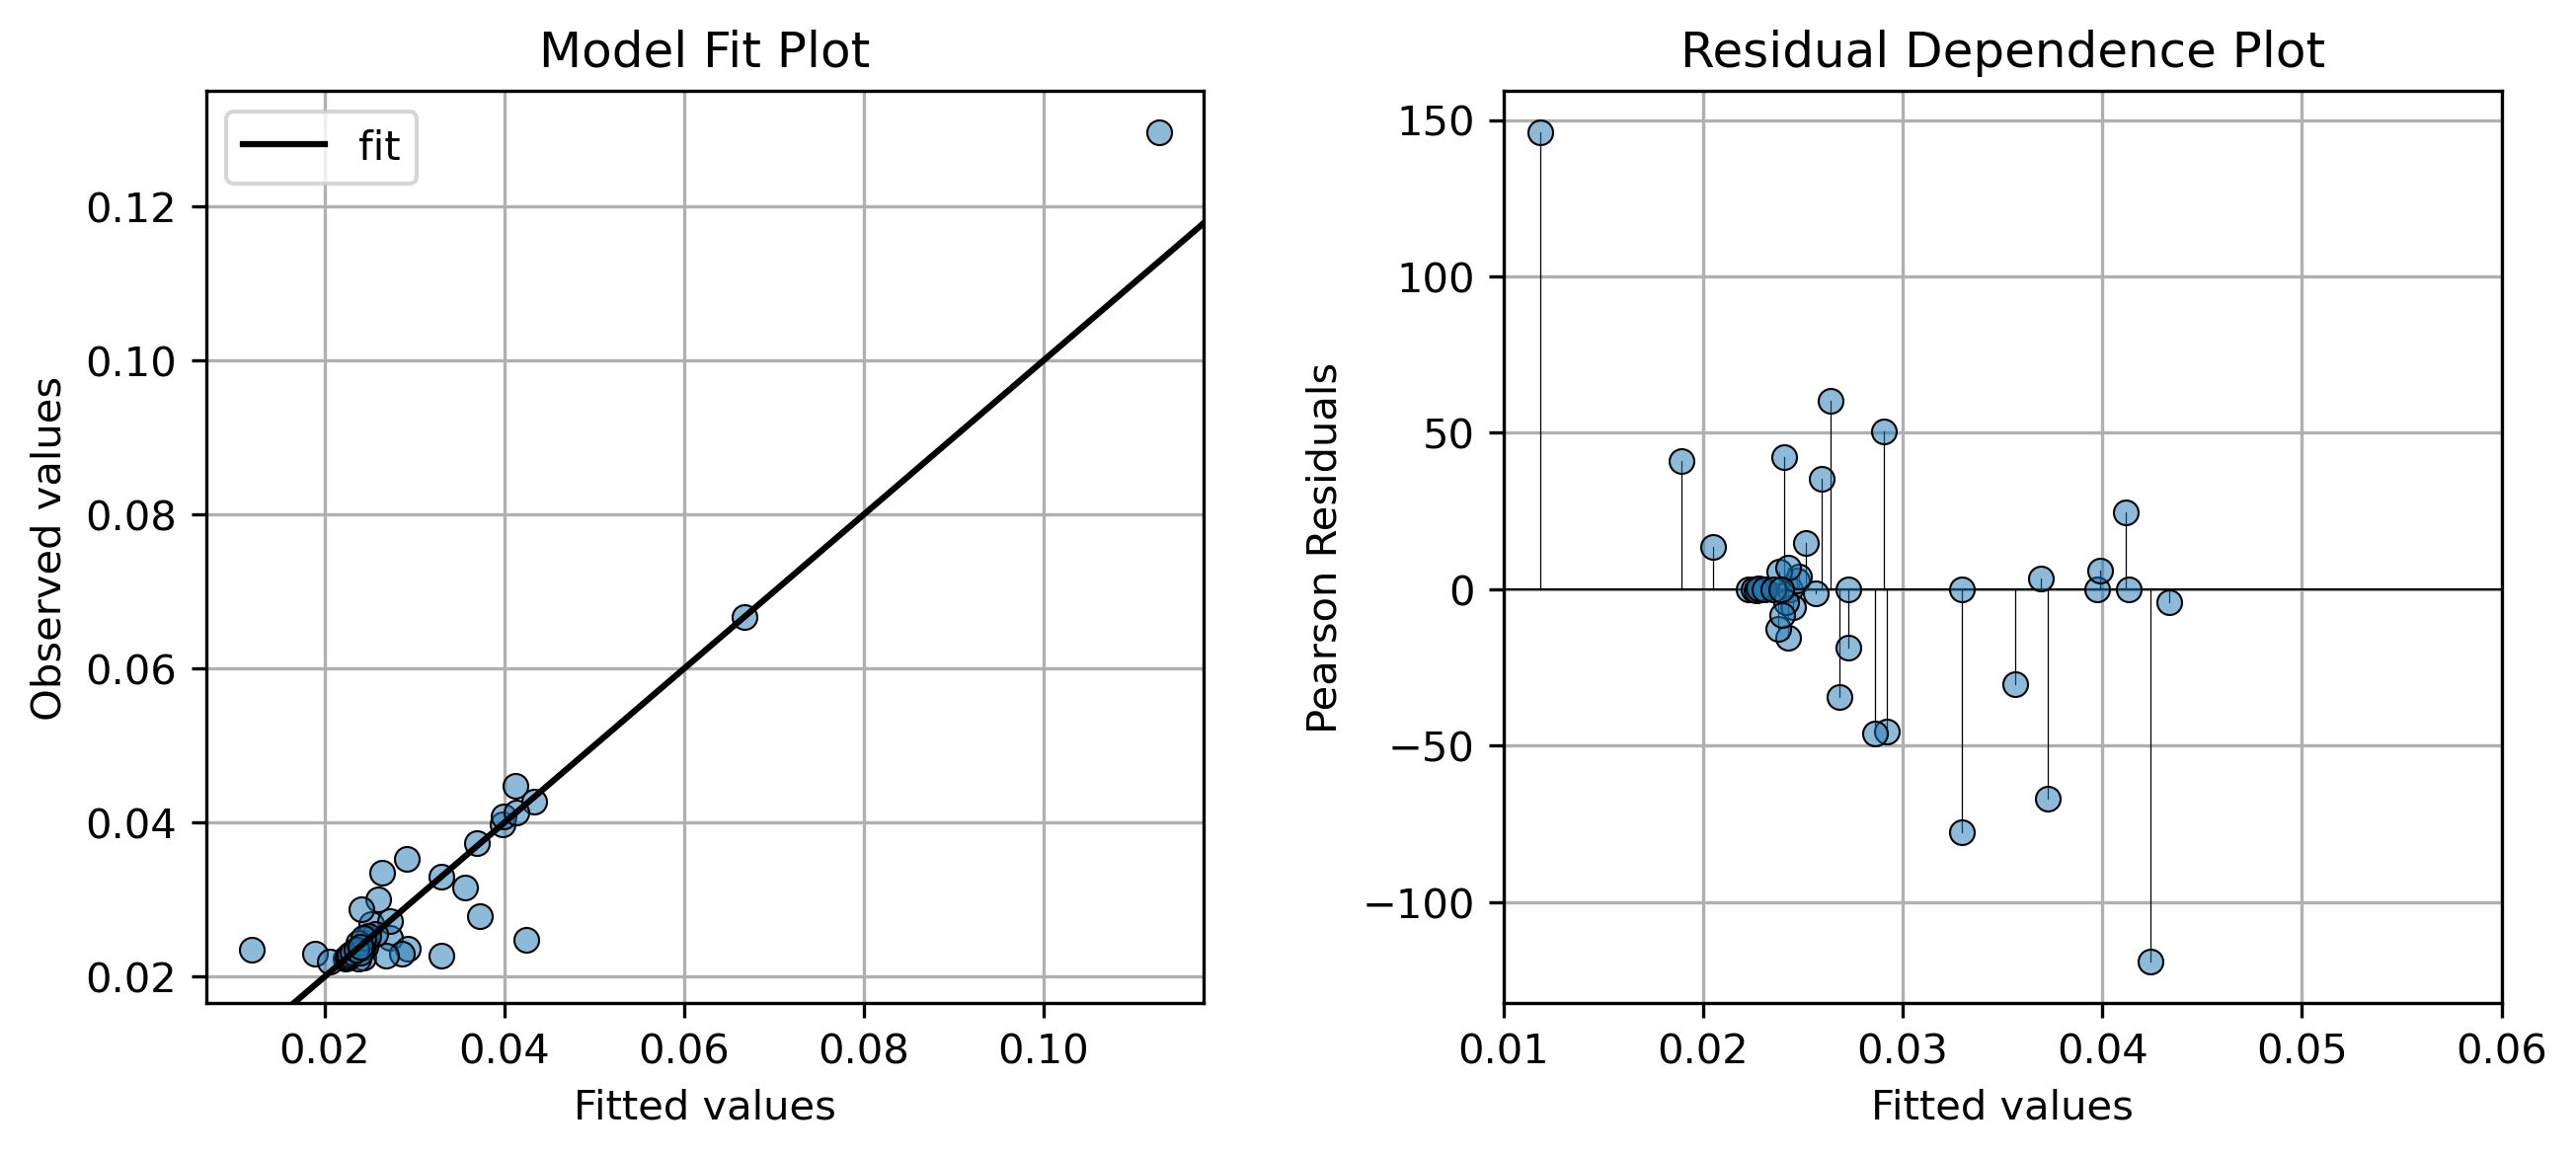

In [42]:
res = do_model('successes+failures ~ coverage + C(treatment) + C(sequencing_run) + generations + coverage:C(treatment) + coverage:C(sequencing_run) + generations:C(treatment) + C(treatment):C(sequencing_run)')

In [43]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       15
Model Family:                       Binomial   Df Model:                           30
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -34622.
Date:                       Sat, 28 Oct 2023   Deviance:                       68662.
Time:                               00:54:05   Pearson chi2:                 7.04e+04
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.6672      0.035     19.062      0.000       0.599       0.736
C(treatment)[T.100Gy]                                     -0.8768      0.016    -56.569      0.000      -0.907      -0.846
C(treatment)[T.250Gy]                                     -0.7756      0.014    -54.939      0.000      -0.803      -0.748
C(treatment)[T.30D]                                        0.0093      0.082      0.114      0.910      -0.151       0.170
C(treatment)[T.30H]                                       -3.1536      0.044    -71.306      0.000      -3.240      -3.067
C(treatment)[T.500Gy]                                     -0.3836      0.258     -1.487      0.137      -0.889       0.122
C(treatment)[T.D]                                         -2.2210      0.041    -54.164      0.000      -2.301      -2.141
C(treatment)[T.H]                                          3.7206      0.041     91.664      0.000       3.641       3.800
C(sequencing_run)[T.GC078]                                 5.6663      0.057     98.961      0.000       5.554       5.779
C(sequencing_run)[T.GC078+GC100]                           1.2047      0.049     24.807      0.000       1.110       1.300
C(sequencing_run)[T.GC087]                                -3.9122      0.029   -136.489      0.000      -3.968      -3.856
C(sequencing_run)[T.GC100]                                -1.6524      0.026    -63.494      0.000      -1.703      -1.601
C(sequencing_run)[T.GC114]                                -0.7013      0.015    -46.597      0.000      -0.731      -0.672
C(treatment)[T.100Gy]:C(sequencing_run)[T.GC078]        -3.81e-13   3.33e-14    -11.437      0.000   -4.46e-13   -3.16e-13
C(treatment)[T.250Gy]:C(sequencing_run)[T.GC078]        1.011e-15   7.69e-16      1.314      0.189   -4.97e-16    2.52e-15
C(treatment)[T.30D]:C(sequencing_run)[T.GC078]            -0.4490      0.114     -3.933      0.000      -0.673      -0.225
C(treatment)[T.30H]:C(sequencing_run)[T.GC078]            -2.2136      0.035    -62.536      0.000      -2.283      -2.144
C(treatment)[T.500Gy]:C(sequencing_run)[T.GC078]           0.6541      0.111      5.901      0.000       0.437       0.871
C(treatment)[T.D]:C(sequencing_run)[T.GC078]              -0.5462      0.043    -12.751      0.000      -0.630      -0.462
C(treatment)[T.H]:C(sequencing_run)[T.GC078]            1.469e-15   3.04e-16      4.830      0.000    8.73e-16    2.07e-15
C(treatment)[T.100Gy]:C(sequencing_run)[T.GC078+GC100]  1.492e-15   9.77e-17     15.263      0.000     1.3e-15    1.68e-15
C(treatment)[T.250Gy]:C(sequencing_run)[T.GC078+GC100]

<a id="glm11"></a>
### GLM 12 gen

AIC:  477810.3222769211


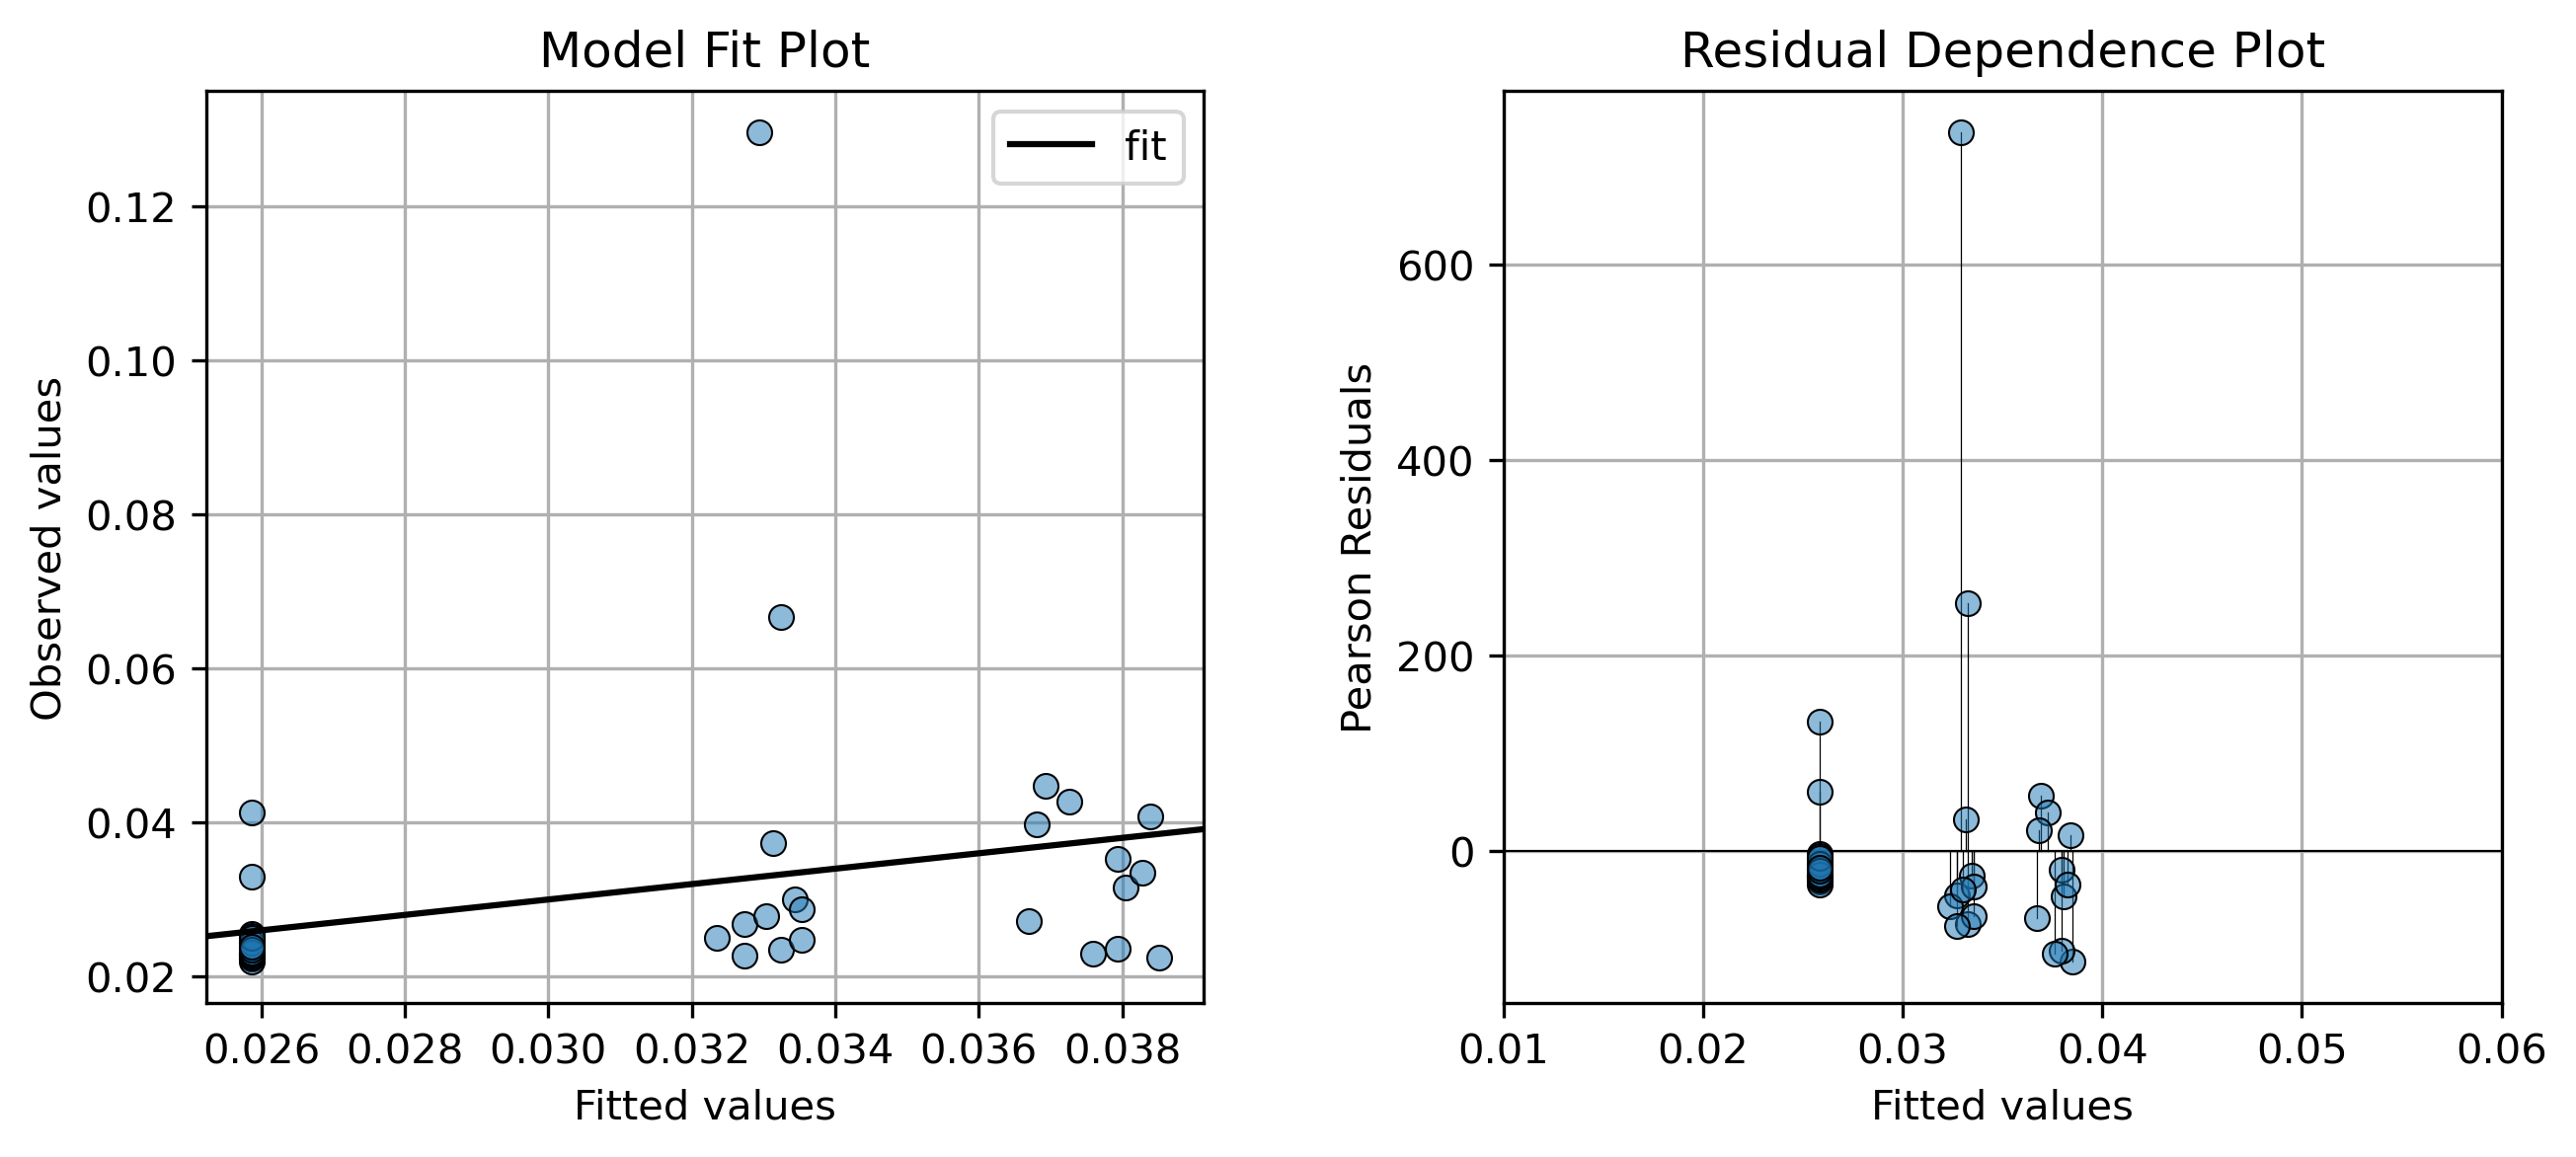

In [44]:
res = do_model('successes+failures ~ generations')

<a id="glm11"></a>
### GLM 13 Seq

AIC:  440344.5156292231


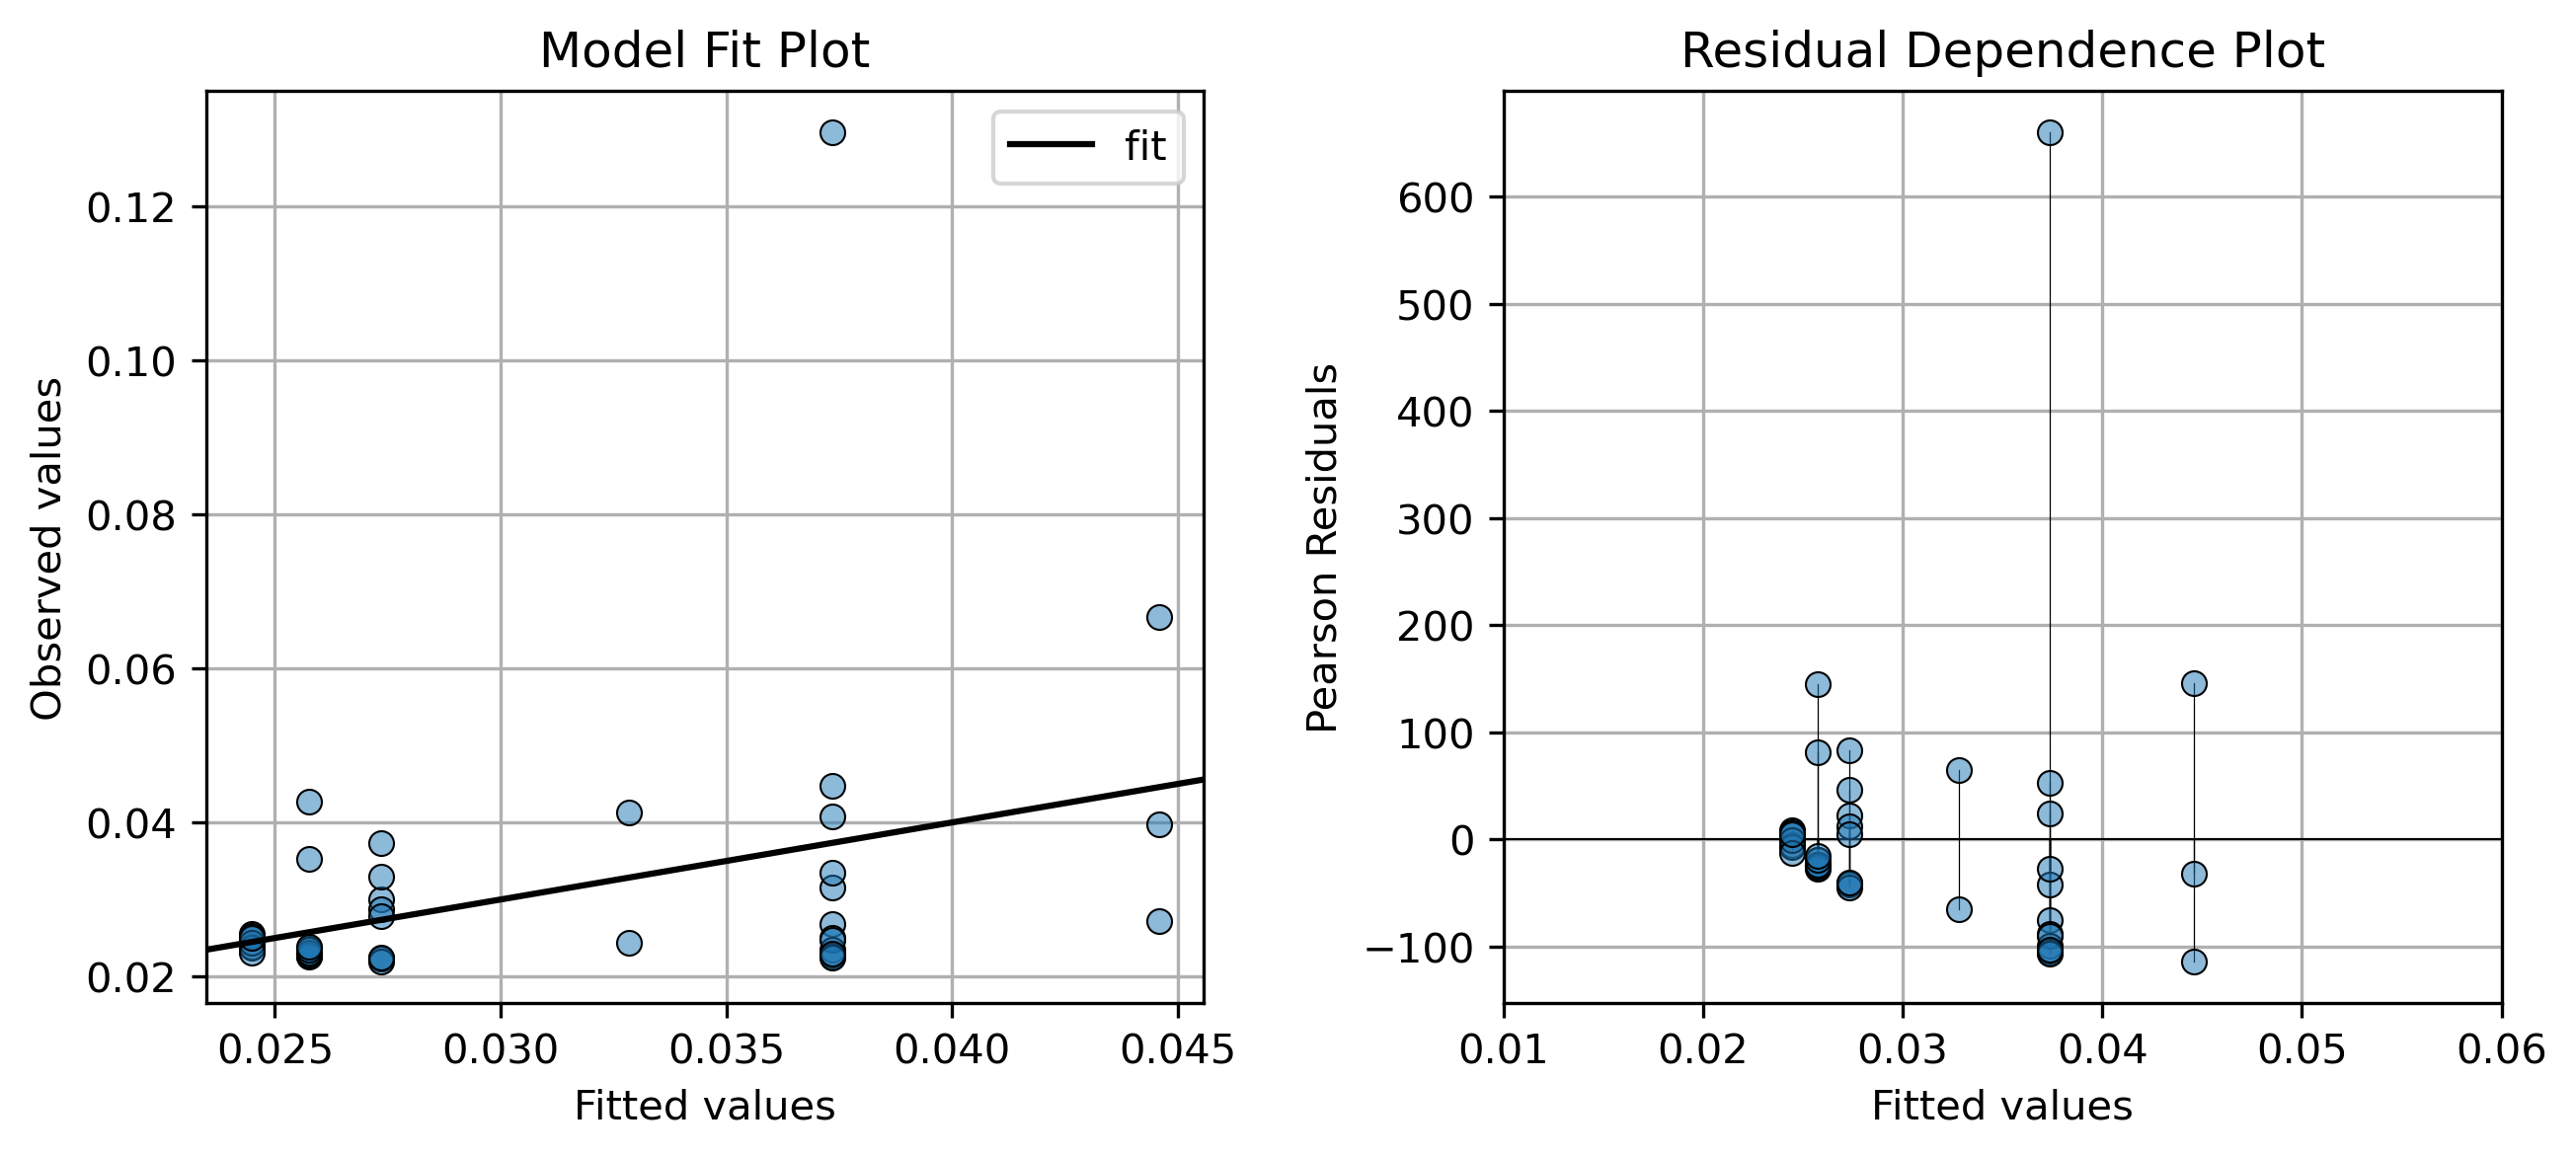

In [45]:
res = do_model('successes+failures ~ C(sequencing_run)')

<a id="glm11"></a>
### GLM 14 Exp

AIC:  444324.2113202406


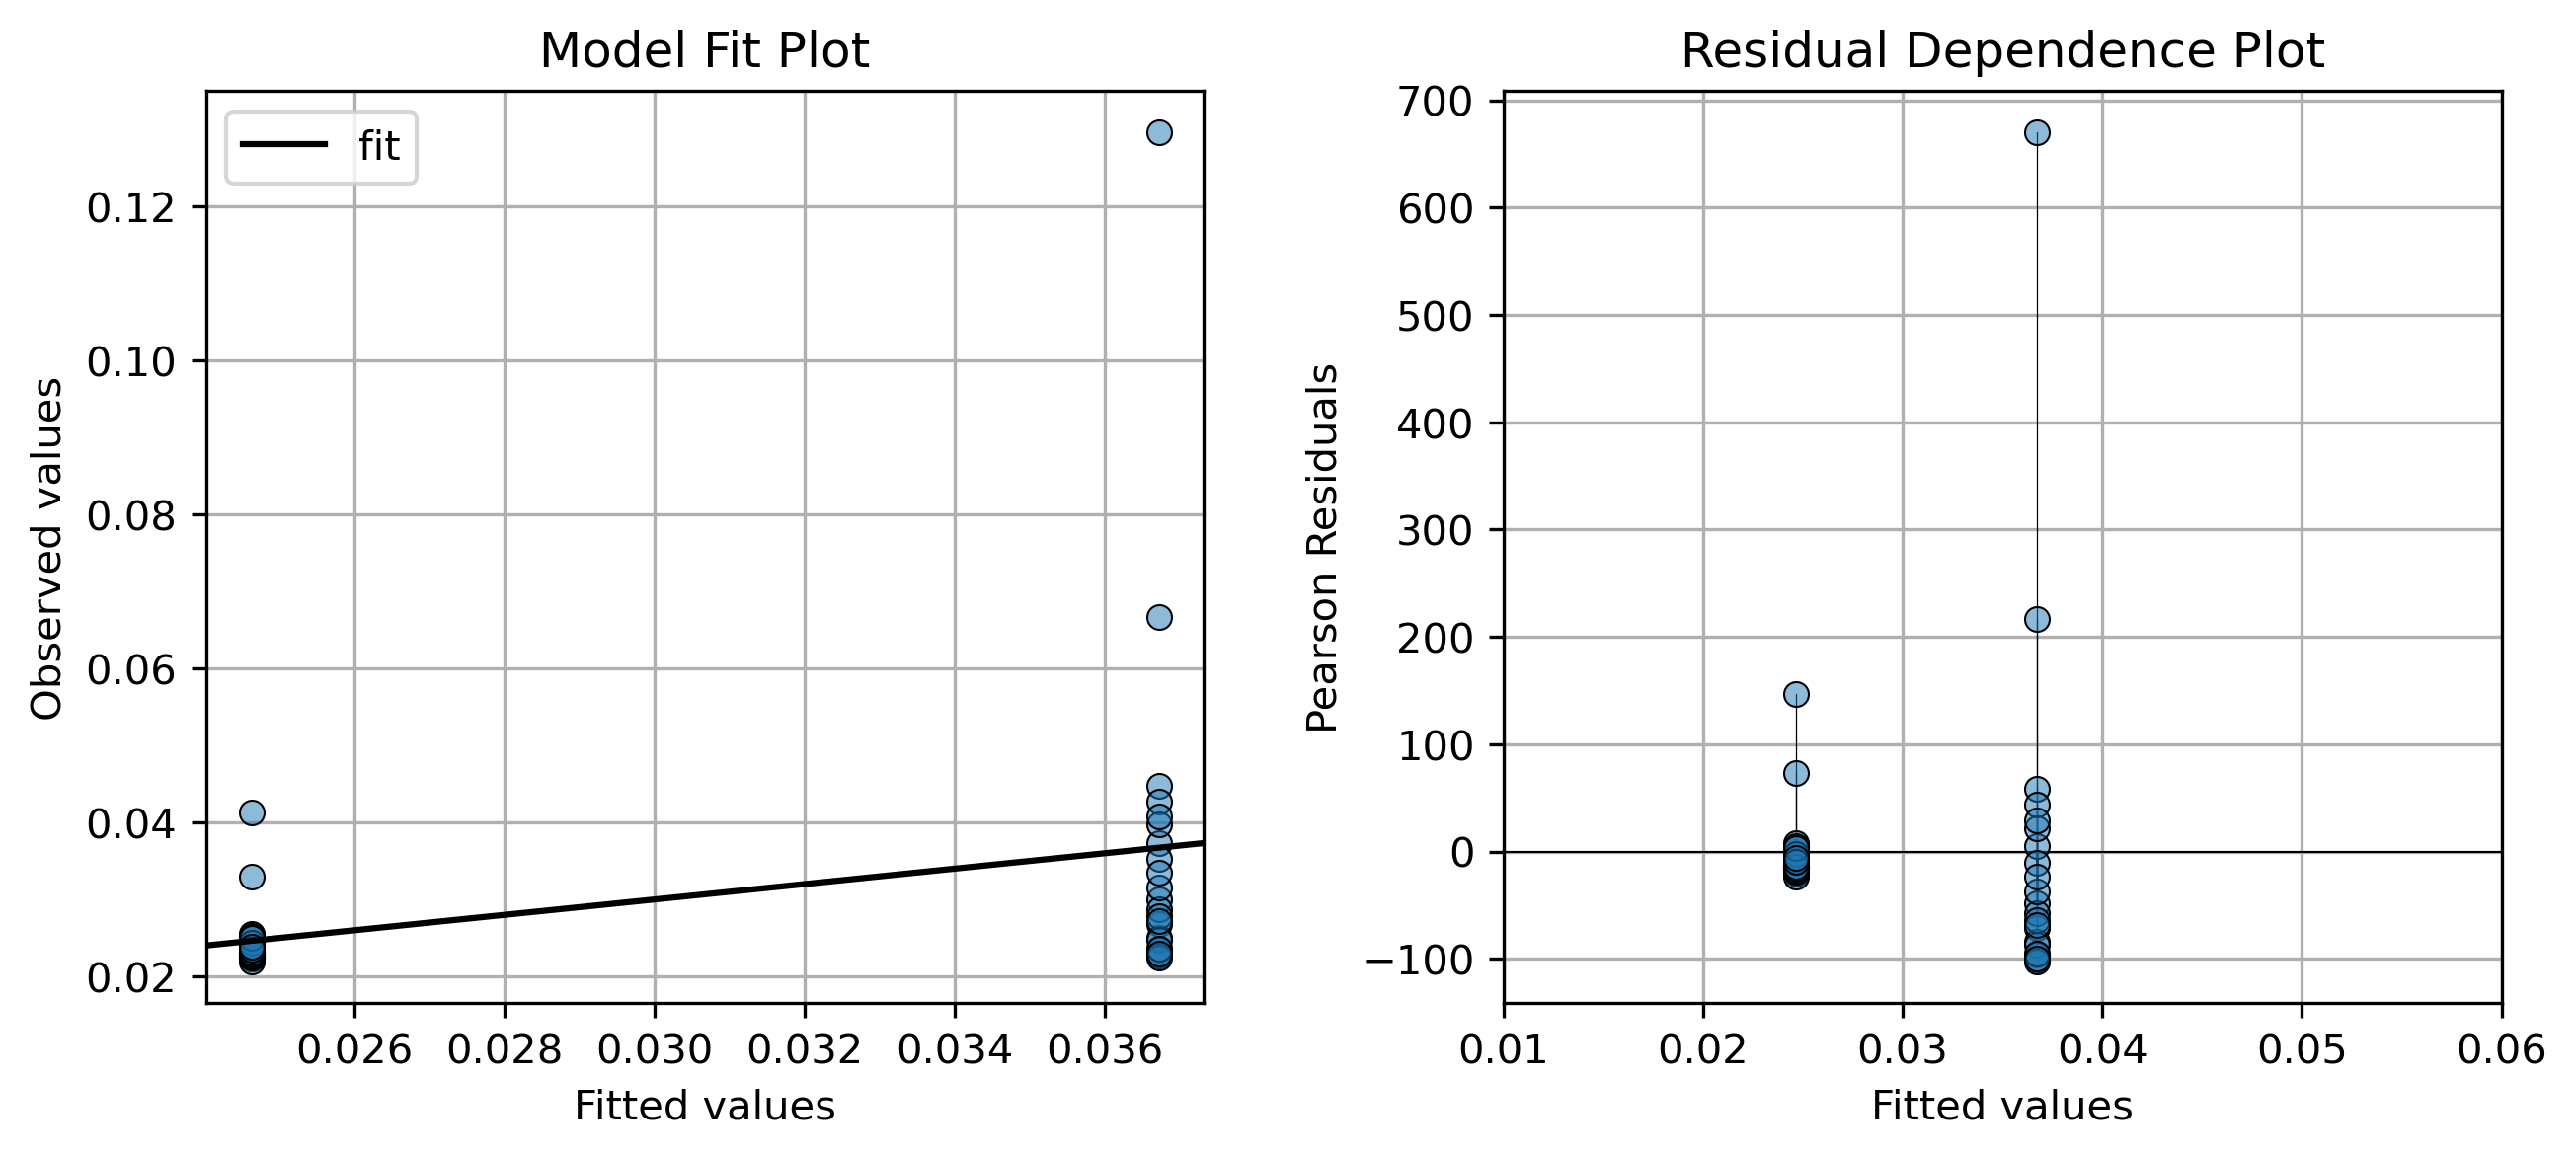

In [46]:
res = do_model('successes+failures ~ C(experiment)')

<a id="glm11"></a>
### GLM 15 Seq + Treat + Seq:Treat

AIC:  356420.6607817955


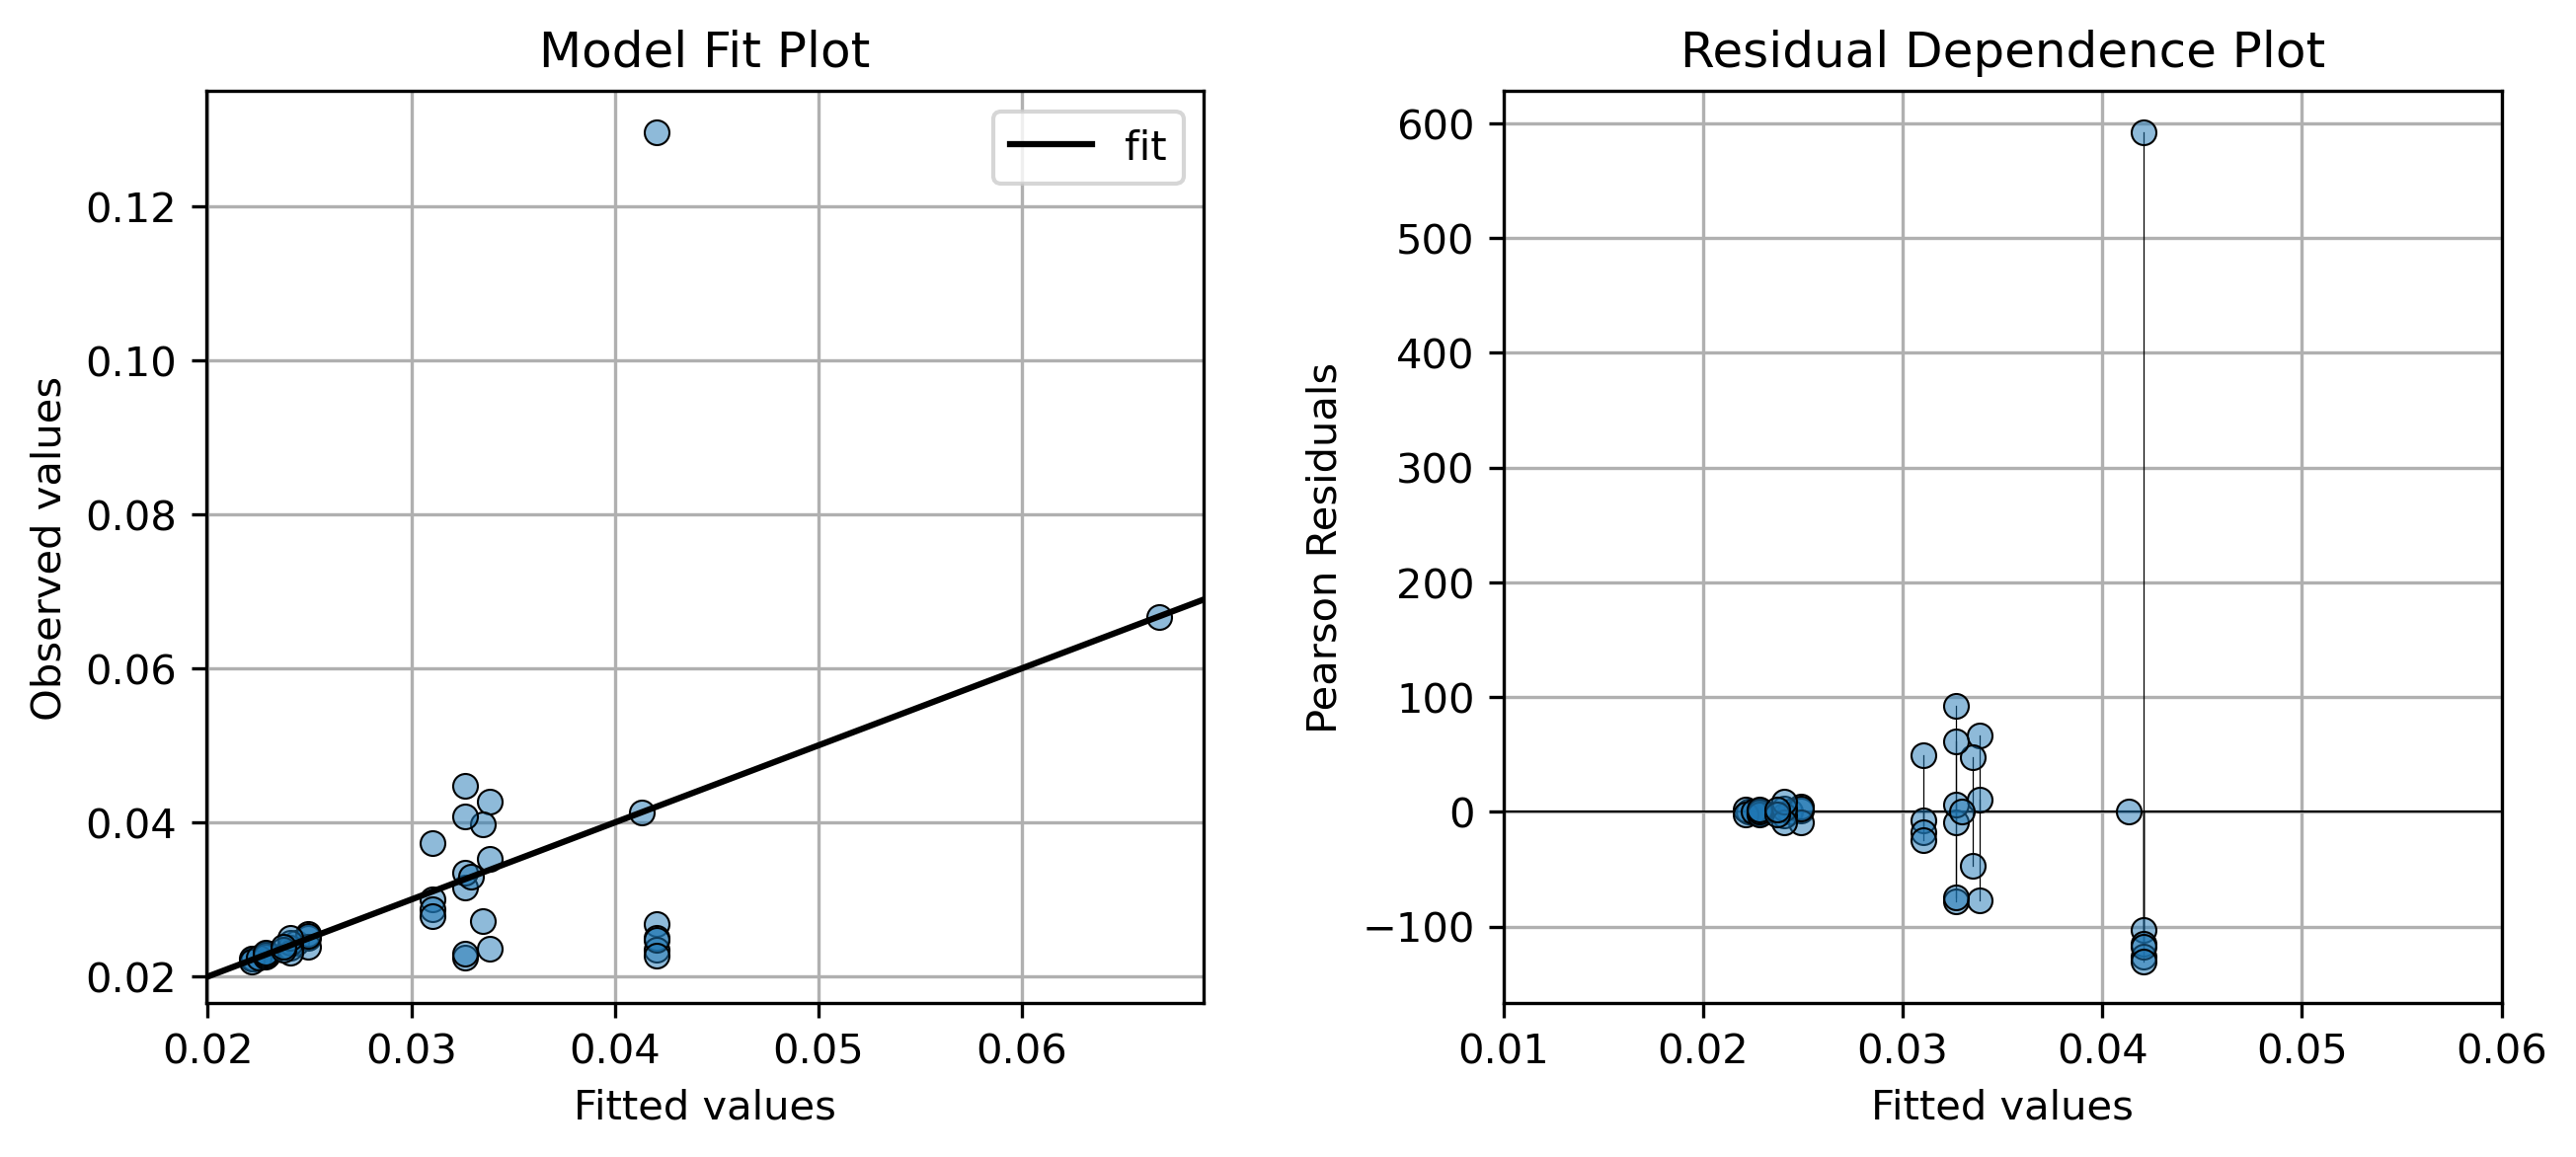

In [47]:
res = do_model('successes+failures ~ C(sequencing_run) + C(treatment) + C(sequencing_run):C(treatment)')

In [49]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                       15
Model Family:                       Binomial   Df Model:                           30
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -34622.
Date:                       Sat, 28 Oct 2023   Deviance:                       68662.
Time:                               00:54:11   Pearson chi2:                 7.04e+04
No. Iterations:                            9   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                0.3465      0.031     11.337      0.000       0.287       0.406
C(sequencing_run)[T.GC078]                               5.0201      0.056     89.278      0.000       4.910       5.130
C(sequencing_run)[T.GC078+GC100]                         1.9184      0.055     35.093      0.000       1.811       2.026
C(sequencing_run)[T.GC087]                              -4.5584      0.045   -101.681      0.000      -4.646      -4.471
C(sequencing_run)[T.GC100]                              -2.0646      0.018   -115.343      0.000      -2.100      -2.029
C(sequencing_run)[T.GC114]                               0.0124      0.021      0.588      0.557      -0.029       0.054
C(treatment)[T.100Gy]:C(sequencing_run)[GC047]         1.36e-12    1.6e-12      0.851      0.395   -1.77e-12    4.49e-12
C(treatment)[T.250Gy]:C(sequencing_run)[GC047]       -4.115e-12   5.86e-13     -7.019      0.000   -5.26e-12   -2.97e-12
C(treatment)[T.30D]:C(sequencing_run)[GC047]             0.1796      0.110      1.634      0.102      -0.036       0.395
C(treatment)[T.30H]:C(sequencing_run)[GC047]         -3.783e-13   7.01e-14     -5.400      0.000   -5.16e-13   -2.41e-13
C(treatment)[T.500Gy]:C(sequencing_run)[GC047]          -0.1610      0.098     -1.635      0.102      -0.354       0.032
C(treatment)[T.D]:C(sequencing_run)[GC047]            1.375e-12   1.16e-14    118.490      0.000    1.35e-12     1.4e-12
C(treatment)[T.H]:C(sequencing_run)[GC047]            1.002e-13   2.35e-13      0.426      0.670   -3.61e-13    5.61e-13
C(treatment)[T.100Gy]:C(sequencing_run)[GC078]        3.135e-13   9.74e-15     32.187      0.000    2.94e-13    3.33e-13
C(treatment)[T.250Gy]:C(sequencing_run)[GC078]        1.725e-14    3.4e-16     50.767      0.000    1.66e-14    1.79e-14
C(treatment)[T.30D]:C(sequencing_run)[GC078]            -0.0905      0.040     -2.283      0.022      -0.168      -0.013
C(treatment)[T.30H]:C(sequencing_run)[GC078]            -3.0487      0.036    -83.740      0.000      -3.120      -2.977
C(treatment)[T.500Gy]:C(sequencing_run)[GC078]           0.6175      0.223      2.772      0.006       0.181       1.054
C(treatment)[T.D]:C(sequencing_run)[GC078]              -1.8001      0.074    -24.205      0.000      -1.946      -1.654
C(treatment)[T.H]:C(sequencing_run)[GC078]            9.049e-15   8.81e-16     10.273      0.000    7.32e-15    1.08e-14
C(treatment)[T.100Gy]:C(sequencing_run)[GC078+GC100] -3.091e-15   7.33e-17    -42.187      0.000   -3.23e-15   -2.95e-15
C(treatment)[T.250Gy]:C(sequencing_run)[GC078+GC100]  1.253e-15   2.62e-16      4.782      0.000    7.

<a id="glm16"></a>
### GLM 16 Cov:Seq:Treat:Gen:Exp

AIC:  25565.985633836914


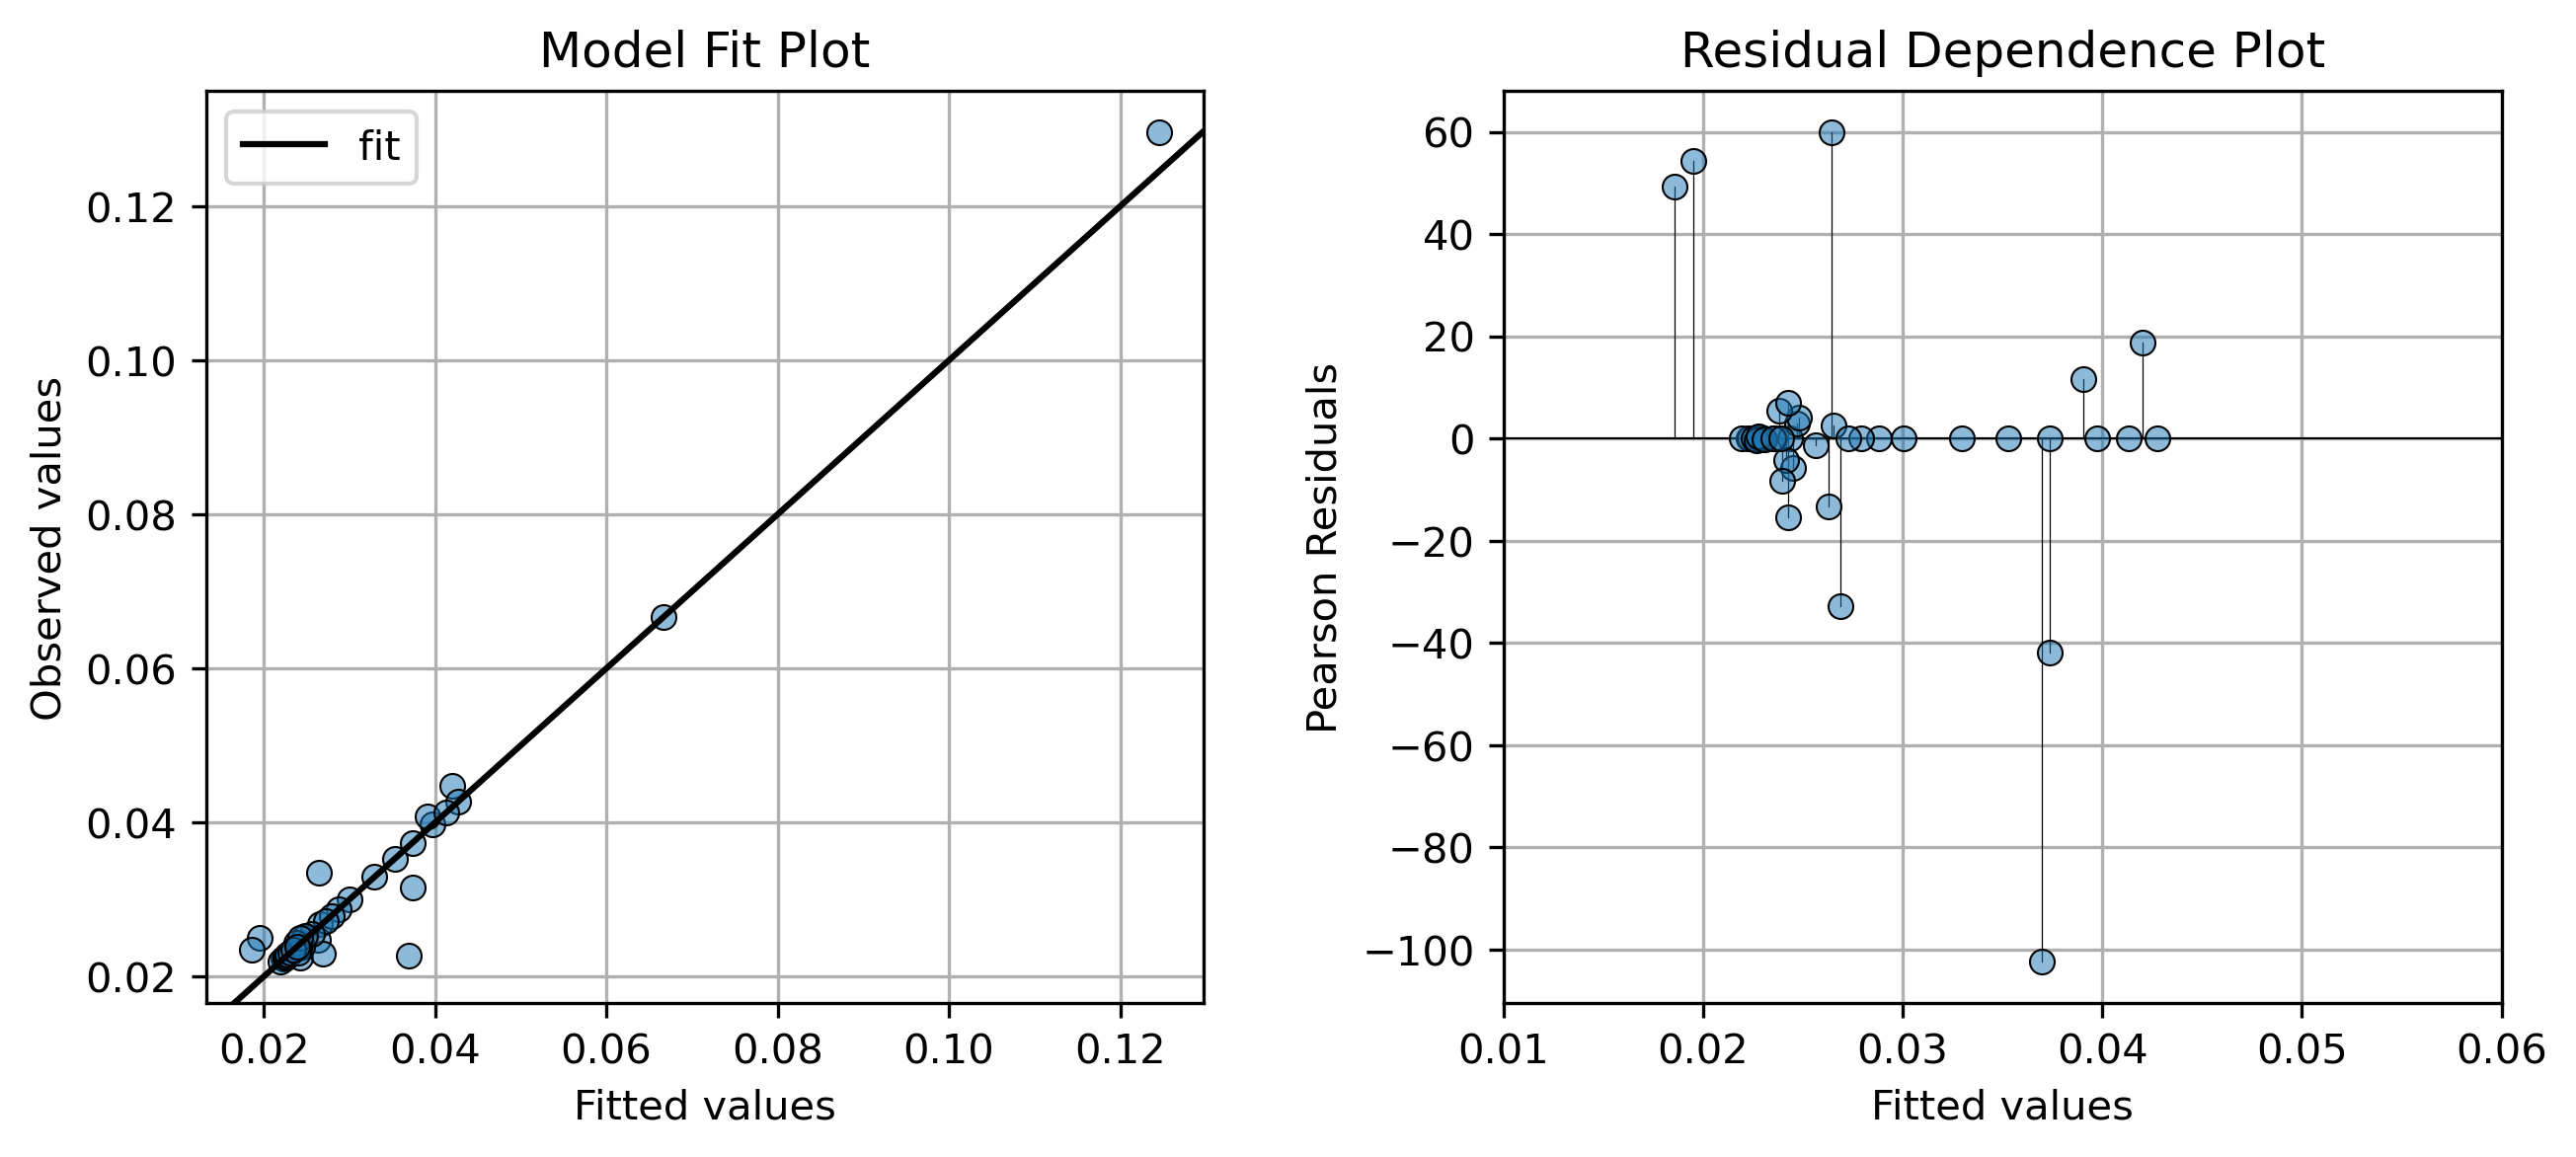

In [66]:
res = do_model('successes+failures ~ coverage*C(sequencing_run)*C(treatment)*generations')

In [59]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     ['successes', 'failures']   No. Observations:                   46
Model:                                   GLM   Df Residuals:                        9
Model Family:                       Binomial   Df Model:                           36
Link Function:                         Logit   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -12746.
Date:                       Sat, 28 Oct 2023   Deviance:                       24909.
Time:                               11:54:54   Pearson chi2:                 2.38e+04
No. Iterations:                            7   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     -14.0916      0.624    -22.567      0.000     -15.315     -12.868
C(sequencing_run)[T.GC078]                                                    -24.0942      1.822    -13.221      0.000     -27.666     -20.522
C(sequencing_run)[T.GC078+GC100]                                               -0.0021      0.000     -8.799      0.000      -0.003      -0.002
C(sequencing_run)[T.GC087]                                                      4.0270      0.220     18.338      0.000       3.597       4.457
C(sequencing_run)[T.GC100]                                                      1.2222      0.070     17.537      0.000       1.086       1.359
C(sequencing_run)[T.GC114]                                                      4.7552      0.923      5.150      0.000       2.945       6.565
C(treatment)[T.100Gy]                                                           0.5731      0.035     16.199      0.000       0.504       0.642
C(treatment)[T.250Gy]                                                           0.6490      0.035     18.480      0.000       0.580       0.718
C(treatment)[T.30D]                                                            -0.0301      0.030     -1.020      0.308      -0.088       0.028
C(treatment)[T.30H]                                                             4.1697      0.300     13.904      0.000       3.582       4.757
C(treatment)[T.500Gy]                                                          -0.3173      0.105     -3.015      0.003      -0.524      -0.111
C(treatment)[T.D]                                                             -37.8716      1.360    -27.850      0.000     -40.537     -35.206
C(treatment)[T.H]                                                              10.1898      0.220     46.362      0.000       9.759      10.621
C(sequencing_run)[T.GC078]:C(treatment)[T.100Gy]                             3.174e-11   1.22e-12     26.032      0.000    2.93e-11    3.41e-11
C(sequencing_run)[T.GC078+GC100]:C(treatment)[T.100Gy]                       2.248e-11    3.8e-13     59.236      0.000    2.17e-11    2.32e-11
C(sequencing_run)[T.GC087]:C(treatment)[T.100Gy]                             1.823e-11   7.54e-13     24.177      0.000    1.67e-11    1.97e-11
C(sequencing_run)[T.GC100]:C(treatment)[T.100Gy]                                0.5731      0.035     16.199      0.000       0.504       0.642
C(sequencing_run)[T.GC114]:C(treatment)[T.100Gy]                             1.553e-11   1.02e-12     15.245      0.000    1.3

## AIC table

In [72]:
models_aic = {
    "M01. All variables":377916.2750935141,
    "M02. Seq + Exp:Gen + Treat:Cov": 226746.16026029276,
    "M03. Cov + Treat": 392073.61945370614, # (same)
    "M04. Cov + Treat + Exp": 392073.6194537061, # (same)
    "M05. Cov:Treat": 301149.7231851615,
    "M06. Cov": 537609.2238401175,
    "M07. Treat": 416642.81670557946,
    "M08. Cov:Treat + Cov:Seq + Exp:Gen": 117051.79373080081, # (same)
    "M09. Exp + Cov:Treat + Cov:Seq": 117051.79371967944, # (same)
    "M10. Cov:Treat + Cov:Seq + Gen:Treat": 112013.08499500425,
    "M11. Cov:Treat + Cov:Seq + Gen:Treat + Treat:Seq": 69306.42680856833,
    "M12. Gen": 477810.3222769211,
    "M13. Seq": 440344.5156292231,
    "M14. Exp": 444324.2113202406,
    "M15. Seq:Treat": 356420.6607817955,
    "M16. Cov:Seq:Treat:Gen (min AIC = 25565.99)": 25565.985633836914,
}

In [75]:
reordered_models_aic = {
    "M01. Cov": 537609.2238401175,
    "M02. Gen": 477810.3222769211,
    "M03. Exp": 444324.2113202406,
    "M04. Seq": 440344.5156292231,
    "M05. Treat": 416642.81670557946,
    "M06. Cov + Treat": 392073.61945370614, # (same)
    "M07. Cov + Treat + Exp": 392073.6194537061, # (same)
    "M08. All variables":377916.2750935141,
    "M09. Seq:Treat": 356420.6607817955,
    "M10. Cov:Treat": 301149.7231851615,
    "M11. Seq + Exp:Gen + Treat:Cov": 226746.16026029276,
    "M12. Cov:Treat + Cov:Seq + Exp:Gen": 117051.79373080081, # (same)
    "M13. Exp + Cov:Treat + Cov:Seq": 117051.79371967944, # (same)
    "M14. Cov:Treat + Cov:Seq + Gen:Treat": 112013.08499500425,
    "M15. Cov:Treat + Cov:Seq + Gen:Treat + Treat:Seq": 69306.42680856833,
    "M16. Cov:Seq:Treat:Gen (min AIC = 25565.99)": 25565.985633836914,
}

In [79]:
reordered_models_aic = dict(sorted(reordered_models_aic.items(), key=lambda item: item[1]))

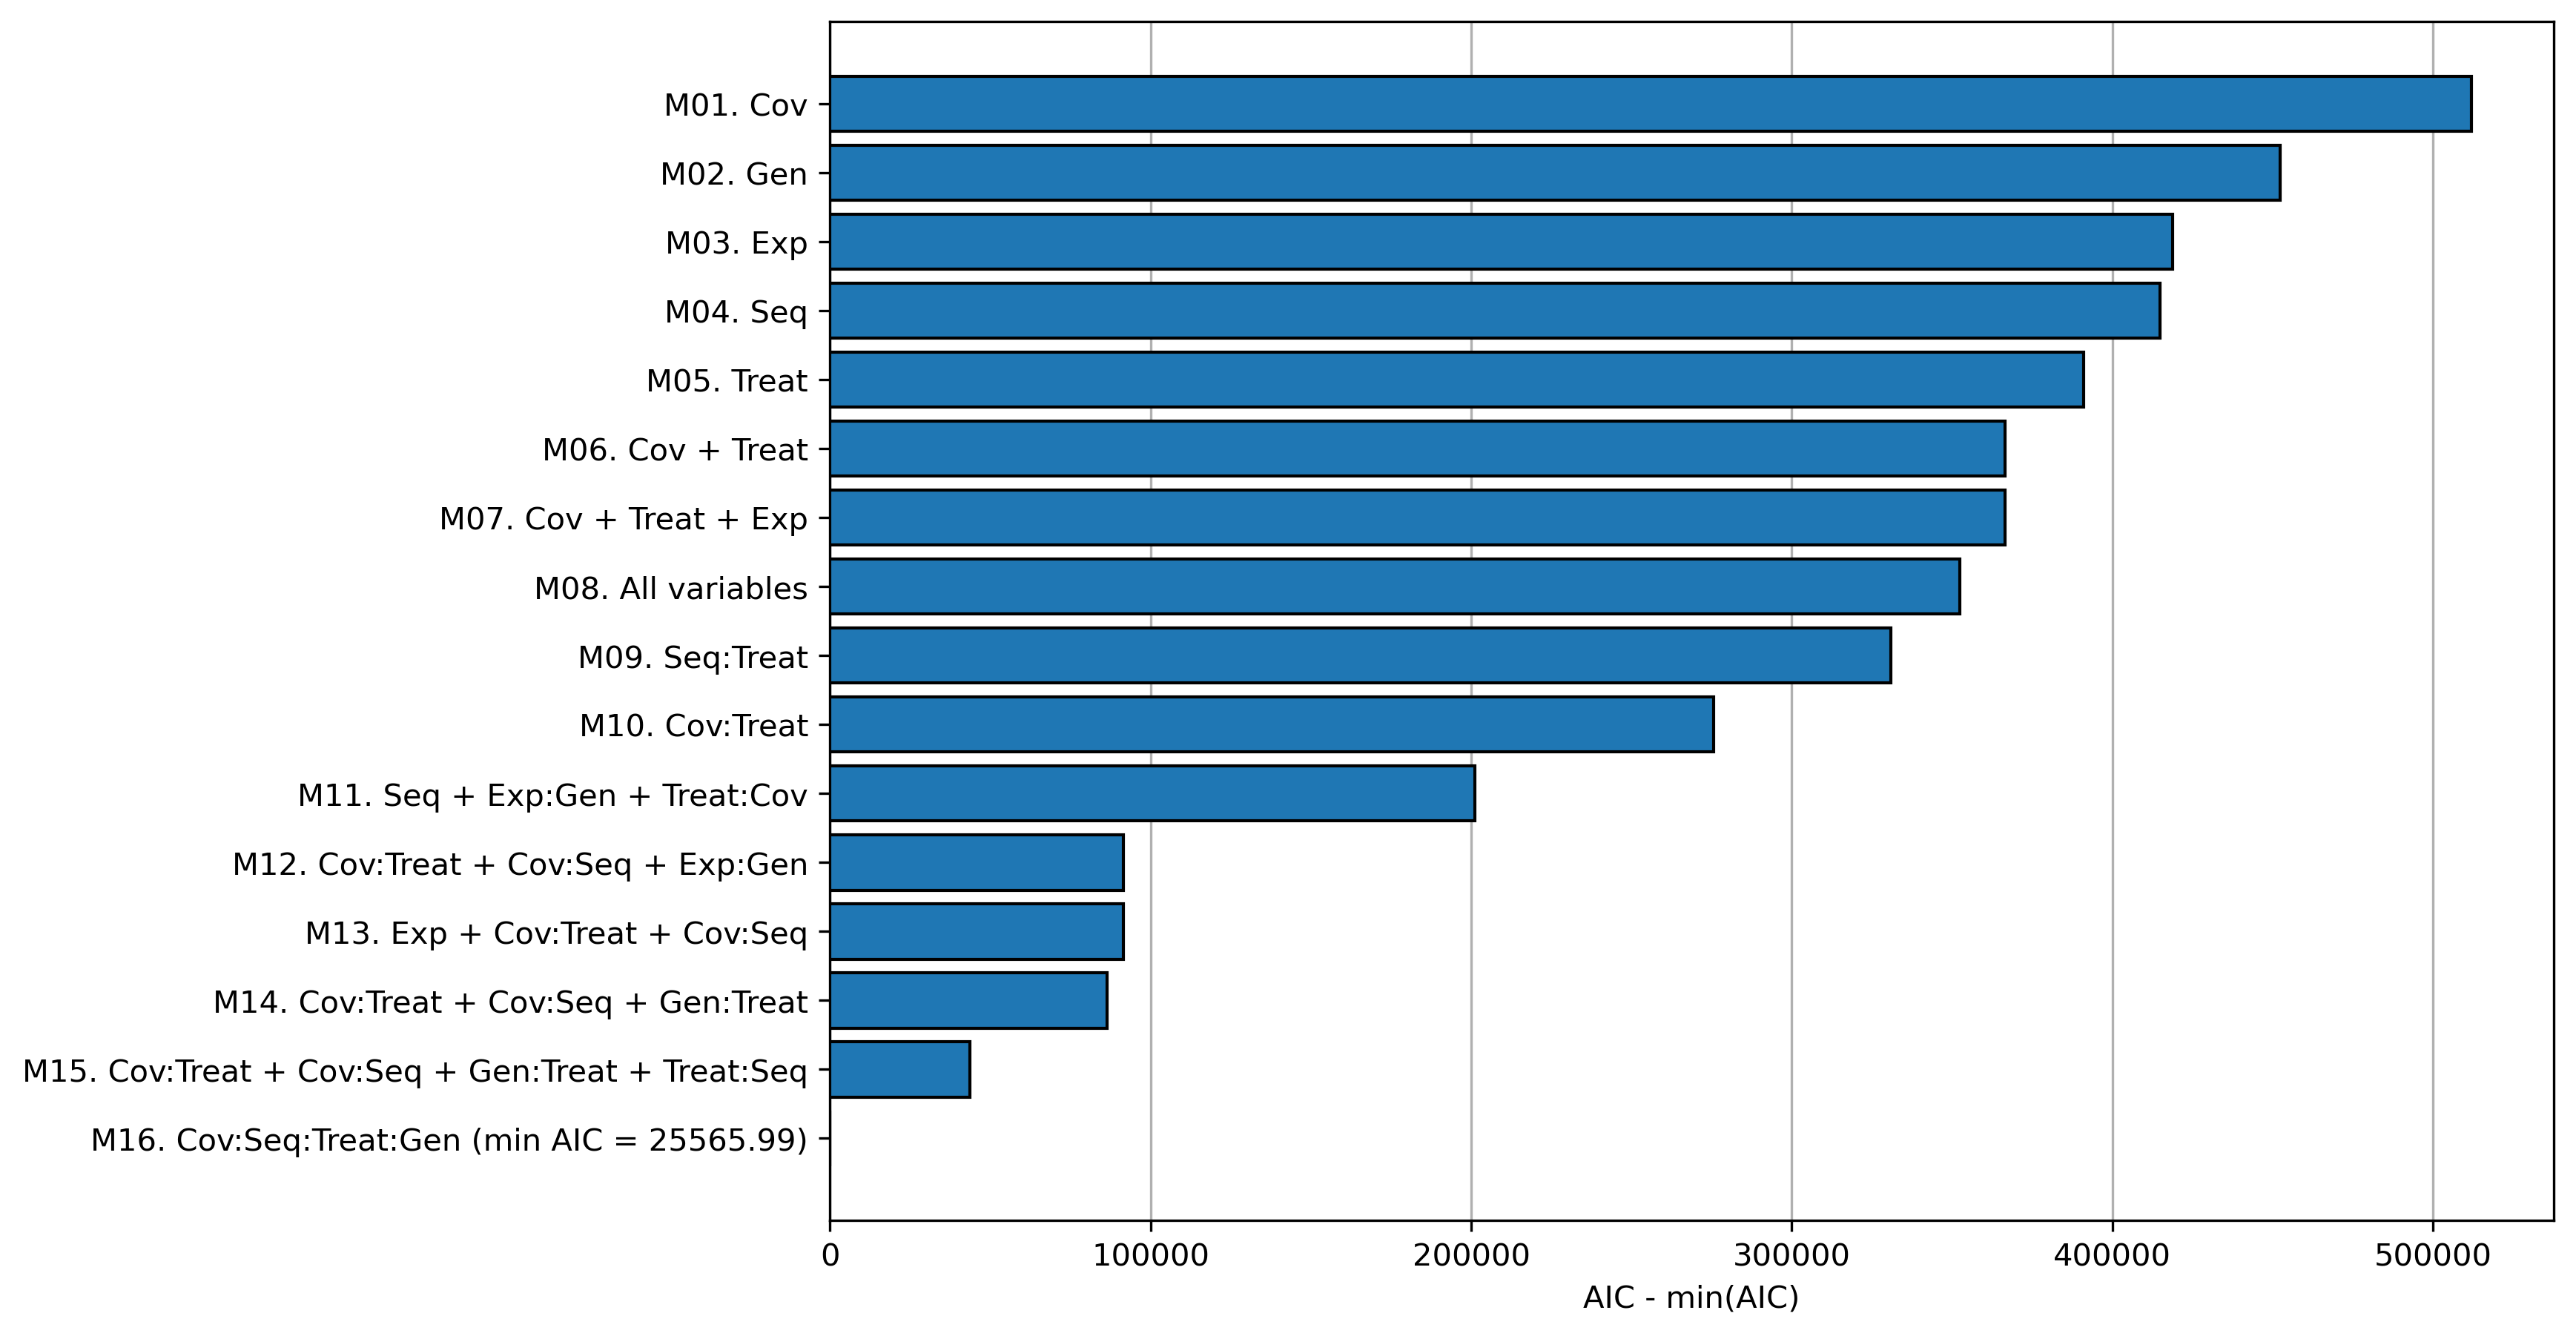

In [80]:
fig, ax = plt.subplots(figsize=(10,7))

min_aic = min(reordered_models_aic.values())
data = [x-min_aic for x in reordered_models_aic.values()]
ax.barh(np.arange(len(reordered_models_aic)), data, ec="k", zorder=5)

ax.set_yticks(np.arange(len(reordered_models_aic)))
ax.set_yticklabels(reordered_models_aic.keys()) #, ha="left")

ax.grid(axis='x', zorder=1)
ax.set_xlabel("AIC - min(AIC)")

plt.show()